# RATIO 2019 - Benchmarking Workshop

https://gluon-nlp.mxnet.io/install.html

```
pip install --upgrade 'mxnet>=1.3.0'
pip install gluonnlp
wget https://gluon-nlp.mxnet.io/_downloads/sentence_embedding.zip
unzip sentence_embedding.zip
ln -s sentence_embedding/bert bert
```

In [72]:
import datetime
import logging
import os
import random
import time
import warnings

import csv
import gluonnlp as nlp
import matplotlib.pyplot as plt
import mxnet as mx
import numpy as np
import pandas as pd
import seaborn as sns

from bert import *
from mxboard import SummaryWriter
from mxnet import gluon
from mxnet.gluon.data import Dataset, SimpleDataset
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score)
from sklearn.model_selection import train_test_split
from sklearn import utils
from tqdm import tqdm

In [73]:
%matplotlib inline

In [74]:
warnings.filterwarnings('ignore')

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',
                    level=logging.INFO)

In [75]:
# set repeatable random state
np.random.seed(100)
random.seed(100)
mx.random.seed(10000)

In [76]:
# apply progress bars for pandas .apply() -> .progress_apply()
tqdm.pandas()

In [77]:
# make tqdm jupyter friendly
from tqdm import tqdm_notebook as tqdm
# for .progress_apply() we have to hack it like this?
tqdm().pandas()

In [78]:
class Timer:
    def __init__(self, name=None):
        self.name = name

    def __enter__(self):
        self.time_start = time.time()

    def __exit__(self, *exc):
        time_end = time.time()
        time_delta = datetime.timedelta(seconds=(time_end - self.time_start))
        if self.name:
            print(("Time for [{}]: {}".format(self.name, time_delta)))
        else:
            print(("Time: {}".format(time_delta)))

# Task 1 - Same Side Classification

In [79]:
data_cross_path = 'data/same-side-classification/cross-topic/{}.csv'
data_within_path = 'data/same-side-classification/within-topic/{}.csv'

### Load within-topics and cross-topics data

In [80]:
with Timer("read cross"):
    cross_traindev_df = pd.read_csv(data_cross_path.format('training'),
                                    quotechar='"',
                                    quoting=csv.QUOTE_ALL,
                                    encoding='utf-8',
                                    escapechar='\\',
                                    doublequote=False,
                                    index_col='id')
    cross_test_df = pd.read_csv(data_cross_path.format('test'), index_col='id')

with Timer("read within"):
    within_traindev_df = pd.read_csv(data_within_path.format('training'),
                                     quotechar='"',
                                     quoting=csv.QUOTE_ALL,
                                     encoding='utf-8',
                                     escapechar='\\',
                                     doublequote=False,
                                     index_col='id')
    # within_test_df = pd.read_csv(data_within_path.format('test'),
    #                              quotechar='"',
    #                              quoting=csv.QUOTE_ALL,
    #                              encoding='utf-8',
    #                              escapechar='\\',
    #                              doublequote=True,  # <-- change, "" as quote escape in text?
    #                              index_col='id')
    within_test_df = pd.read_csv(data_within_path.format('test'), index_col='id')

Time for [read cross]: 0:00:00.849335
Time for [read within]: 0:00:00.820653


In [ ]:
! head -n 5 data/same-side-classification/within-topic/test.csv

In [81]:
# Adding a tag for the topics in focus: "gay marriage" and "abortion"
def add_tag(row):
    title = row['topic'].lower().strip()
    if "abortion" in title:
        row['tag'] = 'abortion'
    elif "gay marriage"  in title:
        row['tag'] = 'gay marriage'
    else:
        row['tag'] = 'NA'
    return row


with Timer("tag cross traindev"):
    cross_traindev_df = cross_traindev_df.progress_apply(add_tag, axis=1)
with Timer("tag cross test"):
    cross_test_df = cross_test_df.progress_apply(add_tag, axis=1)

with Timer("tag within traindev"):
    within_traindev_df = within_traindev_df.progress_apply(add_tag, axis=1)
with Timer("tag within test"):
    within_test_df = within_test_df.progress_apply(add_tag, axis=1)

Time for [tag cross traindev]: 0:00:33.675280


Time for [tag cross test]: 0:00:03.329305


Time for [tag within traindev]: 0:00:35.588848


Time for [tag within test]: 0:00:01.936512


### Get an overview about each dataset

In [82]:
# requires nltk  wordtokenize
# from nltk.tokenize import sent_tokenize, word_tokenize
# model uses BERT Tokenizer ...

def get_overview(df, task='same-side', class_name='is_same_side'):
    # Total instance numbers
    total = len(df)
    print("Task: ", task)
    print('=' * 40, '\n')

    print('Total instances: ', total)
    print('\n')

    print('For each topic:')
    for tag, tag_df in df.groupby(['tag']):
        print(tag, ': ', len(tag_df), ' instances')
        if class_name in df.columns:
            for is_same_side, side_df in tag_df.groupby([class_name]):
                print('\t\t', is_same_side, ': ', len(side_df), ' instances')
    print('\n')

    if class_name in df.columns:
        print('For each class value:')
        for class_value, class_df in df.groupby([class_name]):
            print(class_value, ': ', len(class_df), ' instances')
        print('\n')

    print('Unique argument1:', len(df['argument1'].unique()))
    print('Unique argument2:', len(df['argument2'].unique()))
    arguments = df['argument1'].values
    arguments = np.concatenate([arguments, df['argument2'].values])

    print('Unique total arguments:', len(set(list(arguments))), '\n')
    
    return

    print('-' * 40, '\n')

    arguments_length_lst = [
        len(word_tokenize(x)) for x in df['argument1'].values
    ]
    arguments_length_lst.extend(
        [len(word_tokenize(x)) for x in df['argument2'].values])
    print('Words:')
    print('\tshortest argument:', min(arguments_length_lst), ' words')
    print('\tlongest argument:', max(arguments_length_lst), ' words')
    print('\targument average length:', np.mean(arguments_length_lst),
          ' words')

    arguments_sent_length_lst = [
        len(sent_tokenize(x)) for x in df['argument1'].values
    ]
    arguments_sent_length_lst.extend(
        [len(sent_tokenize(x)) for x in df['argument2'].values])
    print('Sentences:')
    print('\tshortest argument:', min(arguments_sent_length_lst), ' sentences')
    print('\tlongest argument:', max(arguments_sent_length_lst), ' sentences')
    print('\targument average length:', np.mean(arguments_sent_length_lst),
          ' sentences')

In [23]:
with Timer("overview cross"):
    get_overview(cross_traindev_df)

Task:  same-side

Total instances:  61048


For each topic:
abortion :  61048  instances
		 False :  29853  instances
		 True :  31195  instances


For each class value:
False :  29853  instances
True :  31195  instances


Unique argument1: 7828
Unique argument2: 7806
Unique total arguments: 9361 

Time for [overview cross]: 0:00:00.206528


In [24]:
with Timer("overview within"):
    get_overview(within_traindev_df)

Task:  same-side

Total instances:  63903


For each topic:
abortion :  40840  instances
		 False :  20006  instances
		 True :  20834  instances
gay marriage :  23063  instances
		 False :  9786  instances
		 True :  13277  instances


For each class value:
False :  29792  instances
True :  34111  instances


Unique argument1: 10508
Unique argument2: 10453
Unique total arguments: 13574 

Time for [overview within]: 0:00:00.222434


##### Count raw length

In [25]:
def compute_arg_len(row):
    row['argument1_len'] = len(row['argument1'])
    row['argument2_len'] = len(row['argument2'])
    row['argument12_len_diff'] = row['argument1_len'] - row['argument2_len']
    row['argument12_len_diff_abs'] = np.abs(row['argument12_len_diff']
    return row


cross_traindev_df = cross_traindev_df.progress_apply(compute_arg_len, axis=1)
within_traindev_df = within_traindev_df.progress_apply(compute_arg_len, axis=1)
cross_test_df = cross_test_df.progress_apply(compute_arg_len, axis=1)
within_test_df = within_test_df.progress_apply(compute_arg_len, axis=1)

In [26]:
cross_traindev_df.describe()

,argument1_len,argument2_len,argument12_len_diff
count,61048.000000,61048.000000,61048.000000
mean,1182.739091,1020.121953,162.617137
std,1941.477713,1792.400250,1717.589016
min,6.000000,13.000000,-12785.000000
25%,75.000000,75.000000,-249.000000
50%,363.000000,338.000000,8.000000
75%,1160.000000,874.000000,402.000000
max,13320.000000,13320.000000,13179.000000


In [27]:
within_traindev_df.describe()

,argument1_len,argument2_len,argument12_len_diff
count,63903.000000,63903.000000,63903.000000
mean,1139.456332,990.760309,148.696024
std,1906.542592,1761.802828,1673.249280
min,6.000000,13.000000,-12785.000000
25%,68.000000,66.000000,-266.000000
50%,391.000000,346.000000,7.000000
75%,1023.000000,826.000000,421.000000
max,13260.000000,13320.000000,13156.000000


In [28]:
within_test_df.describe()

,argument1_len,argument2_len,argument12_len_diff
count,3552.000000,3552.000000,3552.000000
mean,2261.512950,2072.652590,188.860360
std,2466.410842,2356.729012,2520.665958
min,13.000000,15.000000,-10409.000000
25%,377.000000,353.750000,-676.000000
50%,1230.500000,1059.500000,43.500000
75%,3395.500000,2985.500000,1086.000000
max,12929.000000,13320.000000,9852.000000


##### Tokenize and count tokens

In [29]:
ctx = mx.cpu()
_, vocabulary = nlp.model.get_model('bert_12_768_12',
                                    dataset_name='book_corpus_wiki_en_uncased',
                                    pretrained=True, ctx=ctx, use_pooler=True,
                                    use_decoder=False, use_classifier=False)
bert_tokenizer = nlp.data.BERTTokenizer(vocabulary, lower=True)
tokenizer = bert_tokenizer

In [31]:
from nltk.tokenize import sent_tokenize, word_tokenize
# nltk.download('punct')


# tokenizer from BERT
def tokenize_arguments(row):
    # tokenize
    row['argument1_tokens'] = tokenizer(row['argument1'])
    row['argument2_tokens'] = tokenizer(row['argument2'])

    # count tokens
    row['argument1_len'] = len(row['argument1_tokens'])
    row['argument2_len'] = len(row['argument2_tokens'])
    # token number diff
    row['argument12_len_diff'] = row['argument1_len'] - row['argument2_len']
    row['argument12_len_diff_abs'] = np.abs(row['argument12_len_diff'])
    return row


cross_traindev_df = cross_traindev_df.progress_apply(tokenize_arguments, axis=1)
within_traindev_df = within_traindev_df.progress_apply(tokenize_arguments, axis=1)
cross_test_df = cross_test_df.progress_apply(tokenize_arguments, axis=1)
within_test_df = within_test_df.progress_apply(tokenize_arguments, axis=1)

In [32]:
cross_traindev_df.describe()

,argument1_len,argument2_len,argument12_len_diff,argument12_len_diff_abs
count,61048.000000,61048.000000,61048.000000,61048.000000
mean,264.863337,228.493382,36.369955,199.451563
std,438.187823,405.800206,388.217671,335.043546
min,3.000000,4.000000,-2837.000000,0.000000
25%,18.000000,17.000000,-55.000000,23.000000
50%,83.000000,72.000000,3.000000,71.000000
75%,258.000000,197.000000,88.000000,199.000000
max,2964.000000,2964.000000,2926.000000,2926.000000


In [33]:
within_traindev_df.describe()

,argument1_len,argument2_len,argument12_len_diff,argument12_len_diff_abs
count,63903.000000,63903.000000,63903.000000,63903.000000
mean,252.189647,219.179303,33.010344,190.980486
std,425.471105,393.925258,373.091463,322.199974
min,3.000000,4.000000,-2837.000000,0.000000
25%,15.000000,14.000000,-58.000000,23.000000
50%,85.000000,73.000000,2.000000,75.000000
75%,222.000000,179.000000,91.000000,178.000000
max,2825.000000,2964.000000,2724.000000,2837.000000


In [34]:
within_test_df.describe()

,argument1_len,argument2_len,argument12_len_diff,argument12_len_diff_abs
count,3552.000000,3552.000000,3552.000000,3552.000000
mean,504.283502,462.664414,41.619088,369.798705
std,548.058512,526.286693,562.168586,425.413402
min,4.000000,4.000000,-2733.000000,0.000000
25%,85.000000,78.750000,-153.250000,62.000000
50%,273.000000,238.500000,11.500000,206.000000
75%,767.000000,665.250000,247.250000,517.250000
max,2825.000000,2964.000000,2116.000000,2733.000000


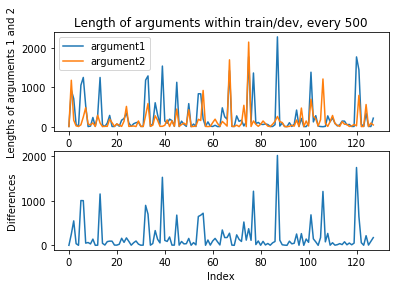

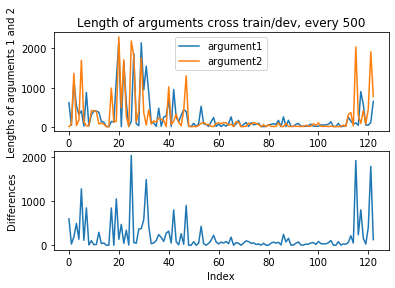

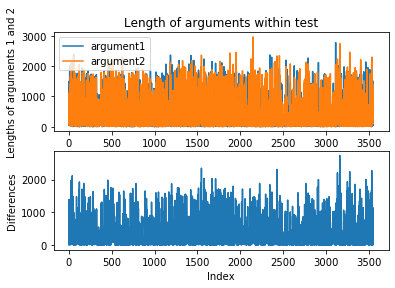

In [35]:
def plot_lengths(df, slicen=None, abs_diff=True, title=None):
    if df is None:
        print("no lengths to plot")
        return
    
    arg1_lens = df['argument1_len']
    arg2_lens = df['argument2_len']
    arg_diff_len = df['argument12_len_diff']
    
    if abs_diff:
        arg_diff_len = np.abs(arg_diff_len)
    
    if slicen is not None:
        arg1_lens = arg1_lens[slicen]
        arg2_lens = arg2_lens[slicen]
        arg_diff_len = arg_diff_len[slicen]

    x = np.arange(len(arg1_lens))  # arange/linspace

    plt.subplot(2, 1, 1)
    plt.plot(x, arg1_lens, label='argument1')  # Linie: '-', 'o-', '.-'
    plt.plot(x, arg2_lens, label='argument2')  # Linie: '-', 'o-', '.-'
    plt.legend()
    plt.title('Lengths of arguments' if not title else title)
    plt.ylabel('Lengths of arguments 1 and 2')

    plt.subplot(2, 1, 2)
    plt.plot(x, arg_diff_len)
    plt.xlabel('Index')
    plt.ylabel('Differences')

    plt.show()


plot_lengths(within_traindev_df, slice(None, None, 500), title='Length of arguments within train/dev, every 500')
plot_lengths(cross_traindev_df, slice(None, None, 500), title='Length of arguments cross train/dev, every 500')
plot_lengths(within_test_df, slice(None, None, 1), title='Length of arguments within test')

## Train model - Baseline

### train dev set - 70% 30%

In [83]:
def get_train_test_sets(df, ratio=0.30, random_state=1):
    X = df[['argument1', 'argument2', 'argument1_id', 'argument2_id', 'topic']]
    y = df[['is_same_side']]

    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=ratio,
                                                        random_state=random_state,
                                                        shuffle=True)
    return X_train, X_test, y_train, y_test

### BERT

- https://gluon-nlp.mxnet.io/examples/sentence_embedding/bert.html

In [84]:
class MyBERTDataset(SimpleDataset):
    def __init__(self, X, y=None):
        self._X = X
        self._y = y
        super(MyBERTDataset, self).__init__(self._convert())

    def _convert(self):
        allsamples = list()

        if self._y is not None:
            df = self._X.merge(self._y, left_index=True, right_index=True)
            for _, row in df.iterrows():
                # allsamples.append([
                #     row['argument1'], row['argument2'],
                #     "1" if str(row['is_same_side']) == "True" else "0"
                # ])
                allsamples.append([
                    row['argument1'], row['argument2'],
                    1 if str(row['is_same_side']) == "True" else 0
                ])

        else:
            for _, row in self._X.iterrows():
                allsamples.append([row['argument1'], row['argument2'], None])

        return allsamples

###### my own `BERTDatasetTransform` for extracting chunks from arguments or last part etc.

```python
transform = dataset.BERTDatasetTransform(bert_tokenizer, 512,
                                         labels=['0', '1'],
                                         label_dtype='int32',
                                         pad=True,
                                         pair=True)
```

http://localhost:9001/edit/bert/dataset.py @454
```python
# substitute with my own (e. g. last part, many parts etc.)
def __init__(...):
    self._bert_xform = BERTSentenceTransform(tokenizer, max_seq_length, pad=pad, pair=pair)
```
https://gluon-nlp.mxnet.io/master/_modules/gluonnlp/data/transforms.html#BERTSentenceTransform
```python
# substitute with my own (e. g. only last part (trim from start))
self._truncate_seq_pair(tokens_a, tokens_b, self._max_seq_length - 3)
```

https://mxnet.incubator.apache.org/_modules/mxnet/gluon/data/dataset.html#Dataset.transform

In [85]:
from gluonnlp.data import BERTSentenceTransform


class FirstAndLastPartBERTSentenceTransform(BERTSentenceTransform):
    def __init__(self, tokenizer, max_seq_length, pad=True, pair=True):
        super(FirstAndLastPartBERTSentenceTransform,
              self).__init__(tokenizer, max_seq_length, pad=pad, pair=pair)

    def __call__(self, line):
        # convert to unicode
        text_a = line[0]
        if self._pair:
            assert len(line) == 2
            text_b = line[1]

        tokens_a = self._tokenizer(text_a)
        tokens_a_epi = tokens_a.copy()
        tokens_b = None
        tokens_b_epi = None

        if self._pair:
            tokens_b = self._tokenizer(text_b)
            tokens_b_epi = tokens_b.copy()

        if tokens_b:
            self._truncate_seq_pair_prolog(tokens_a, tokens_b,
                                           self._max_seq_length - 3)
            self._truncate_seq_pair_epilog(tokens_a_epi, tokens_b_epi,
                                           self._max_seq_length - 3)
        else:
            if len(tokens_a) > self._max_seq_length - 2:
                tokens_a = tokens_a[0:(self._max_seq_length - 2)]
            if len(tokens_a_epi) > self._max_seq_length - 2:
                tokens_a_epi = tokens_a_epi[0:(self._max_seq_length - 2)]

        vocab = self._tokenizer.vocab
        tokens, tokens_epi = [], []
        tokens.append(vocab.cls_token)
        tokens_epi.append(vocab.cls_token)
        tokens.extend(tokens_a)
        tokens_epi.extend(tokens_a_epi)
        tokens.append(vocab.sep_token)
        tokens_epi.append(vocab.sep_token)
        segment_ids = [0] * len(tokens)
        segment_ids_epi = [0] * len(tokens_epi)

        if tokens_b:
            tokens.extend(tokens_b)
            tokens_epi.extend(tokens_b_epi)
            tokens.append(vocab.sep_token)
            tokens_epi.append(vocab.sep_token)
            segment_ids.extend([1] * (len(tokens) - len(segment_ids)))
            segment_ids_epi.extend([1] * (len(tokens) - len(segment_ids_epi)))

        input_ids = self._tokenizer.convert_tokens_to_ids(tokens)
        input_ids_epi = self._tokenizer.convert_tokens_to_ids(tokens_epi)
        valid_length = len(input_ids)
        valid_length_epi = len(input_ids_epi)

        if self._pad:
            padding_length = self._max_seq_length - valid_length
            padding_length_epi = self._max_seq_length - valid_length_epi
            input_ids.extend([vocab[vocab.padding_token]] * padding_length)
            input_ids_epi.extend([vocab[vocab.padding_token]] *
                                 padding_length_epi)
            segment_ids.extend([0] * padding_length)
            segment_ids_epi.extend([0] * padding_length_epi)

        return np.array(input_ids, dtype='int32'), np.array(valid_length, dtype='int32'),\
            np.array(segment_ids, dtype='int32'), np.array(input_ids_epi, dtype='int32'),\
            np.array(valid_length_epi, dtype='int32'), np.array(segment_ids_epi, dtype='int32')

    def _truncate_seq_pair_prolog(self, tokens_a, tokens_b, max_length):
        """Truncates a sequence pair in place to the maximum length."""
        # This is a simple heuristic which will always truncate the longer sequence
        # one token at a time. This makes more sense than truncating an equal percent
        # of tokens from each, since if one sequence is very short then each token
        # that's truncated likely contains more information than a longer sequence.
        while True:
            total_length = len(tokens_a) + len(tokens_b)
            if total_length <= max_length:
                break
            if len(tokens_a) > len(tokens_b):
                tokens_a.pop()
            else:
                tokens_b.pop()

    def _truncate_seq_pair_epilog(self, tokens_a, tokens_b, max_length):
        """Truncates a sequence pair in place to the maximum length.
        Removes from end of token list."""
        # This is a simple heuristic which will always truncate the longer sequence
        # one token at a time. This makes more sense than truncating an equal percent
        # of tokens from each, since if one sequence is very short then each token
        # that's truncated likely contains more information than a longer sequence.
        while True:
            total_length = len(tokens_a) + len(tokens_b)
            if total_length <= max_length:
                break
            if len(tokens_a) > len(tokens_b):
                tokens_a.pop(0)
            else:
                tokens_b.pop(0)

In [118]:
class FirstAndLastPartBERTDatasetTransform(dataset.BERTDatasetTransform):
    def __init__(self,
                 tokenizer,
                 max_seq_length,
                 labels=None,
                 pad=True,
                 pair=True,
                 label_dtype='float32'):
        super(FirstAndLastPartBERTDatasetTransform,
              self).__init__(tokenizer,
                             max_seq_length,
                             labels=labels,
                             pad=pad,
                             pair=pair,
                             label_dtype=label_dtype)
        self._bert_xform = FirstAndLastPartBERTSentenceTransform(
            tokenizer, max_seq_length, pad=pad, pair=pair)

    def __call__(self, line):
        input_ids, valid_length, segment_ids, input_ids_epi, valid_length_epi, segment_ids_epi = self._bert_xform(
            line[:-1])

        label = line[-1]

        # if label is None than we are predicting unknown data
        if label is None:
            # early abort
            return input_ids, valid_length, segment_ids, input_ids_epi, valid_length_epi, segment_ids_epi
            
        if self.labels:  # for classification task
            label = self._label_map[label]
        label = np.array([label], dtype=self.label_dtype)

        return input_ids, valid_length, segment_ids, input_ids_epi, valid_length_epi, segment_ids_epi, label

In [87]:
from mxnet.gluon import Block
from mxnet.gluon import nn


class BERTProEpiClassifier(Block):
    """Model for sentence (pair) classification task with BERT.

    The model feeds token ids and token type ids into BERT to get the
    pooled BERT sequence representation, then apply a Dense layer for
    classification. Does this also for an adversarial classifier.

    Parameters
    ----------
    bert: BERTModel
        Bidirectional encoder with transformer.
    num_classes : int, default is 2
        The number of target classes.
    dropout : float or None, default 0.0.
        Dropout probability for the bert output.
    prefix : str or None
        See document of `mx.gluon.Block`.
    params : ParameterDict or None
        See document of `mx.gluon.Block`.
    """

    def __init__(self,
                 bert,
                 num_classes=2,
                 dropout=0.0,
                 prefix=None,
                 params=None):
        super(BERTProEpiClassifier, self).__init__(prefix=prefix, params=params)
        self.bert = bert
        with self.name_scope():
            self.classifier = nn.HybridSequential(prefix=prefix)
            if dropout:
                self.classifier.add(nn.Dropout(rate=dropout))
            self.classifier.add(nn.Dense(units=num_classes))

    def forward(self,
                inputs,
                token_types,
                valid_length=None,
                inputs_epi=None,
                token_types_epi=None,
                valid_length_epi=None):  # pylint: disable=arguments-differ
        """Generate the unnormalized scores for the given the input sequences.
        From both classifiers (classifier + adversarial_classifier).

        Parameters
        ----------
        inputs : NDArray, shape (batch_size, seq_length)
            Input words for the sequences.
        token_types : NDArray, shape (batch_size, seq_length)
            Token types for the sequences, used to indicate whether the word belongs to the
            first sentence or the second one.
        valid_length : NDArray or None, shape (batch_size)
            Valid length of the sequence. This is used to mask the padded tokens.
        inputs_epi : NDArray or None, shape (batch_size, seq_length)
            Input words for the sequences. If None then same as inputs.
        token_types_epi : NDArray or None, shape (batch_size, seq_length)
            Token types for the sequences, used to indicate whether the word belongs to the
            first sentence or the second one. If None then same as token_types.
        valid_length_epi : NDArray or None, shape (batch_size)
            Valid length of the sequence. This is used to mask the padded tokens.

        Returns
        -------
        outputs : NDArray
            Shape (batch_size, num_classes), outputs of classifier.
        """
        # if inputs_epi is None and token_types_epi is None:
        #     inputs_epi = inputs
        #     token_types_epi = token_types
        #     valid_length_epi = valid_length

        _, pooler_out = self.bert(inputs, token_types, valid_length)
        _, pooler_out_epi = self.bert(inputs_epi, token_types_epi, valid_length_epi)
        pooler_concat = mx.nd.concat(pooler_out, pooler_out_epi, dim=1)
        return self.classifier(pooler_concat)

In [88]:
def setup_bert():
    # change `ctx` to `mx.cpu()` if no GPU is available.
    ctx = mx.gpu(0)
    # ctx = [mx.gpu(i) for i in range(2)]
    # ctx =  mx.gpu() if mx.context.num_gpus() else mx.cpu()
    # ctx = mx.cpu()

    bert_base, vocabulary = nlp.model.get_model(
        'bert_12_768_12',
        dataset_name='book_corpus_wiki_en_uncased',
        pretrained=True,
        ctx=ctx,
        use_pooler=True,
        use_decoder=False,
        use_classifier=False)
    print(bert_base)

    #model = BERTProEpiClassifier(bert_base, num_classes=2, dropout=0.1)
    model = BERTProEpiClassifier(bert_base, num_classes=1, dropout=0.1)
    # only need to initialize the classifier layer.
    model.classifier.initialize(init=mx.init.Normal(0.02), ctx=ctx)
    model.hybridize(static_alloc=True)

    # softmax cross entropy loss for classification
    #loss_function = gluon.loss.SoftmaxCELoss()
    loss_function = gluon.loss.SigmoidBinaryCrossEntropyLoss(from_sigmoid=False)
    loss_function.hybridize(static_alloc=True)

    metric = mx.metric.Accuracy()

    # use the vocabulary from pre-trained model for tokenization
    bert_tokenizer = nlp.data.BERTTokenizer(vocabulary, lower=True)
    # maximum sequence length
    # max_len = 128  # + batch_size: 32
    # 384 - 12
    max_len = 512  # + batch_size: 6 ?
    # the labels for the two classes
    #all_labels = ["0", "1"]
    all_labels = [0, 1]
    # whether to transform the data as sentence pairs.
    # for single sentence classification, set pair=False
    transform = FirstAndLastPartBERTDatasetTransform(bert_tokenizer,
                                                     max_len,
                                                     labels=all_labels,
                                                     label_dtype='int32',
                                                     pad=True,
                                                     pair=True)

    return model, vocabulary, ctx, bert_tokenizer, transform, loss_function, metric, all_labels

In [89]:
def transform_dataset(X, y, transform):
    data_train_raw = MyBERTDataset(X, y)
    data_train = data_train_raw.transform(transform)
    return data_train_raw, data_train


def predict_out_to_ys(all_predictions, all_labels):
    y_true, y_pred = list(), list()

    for _, y_true_many, y_pred_many in all_predictions:
        y_true_many = y_true_many.T[0].asnumpy()
        # https://mxnet.incubator.apache.org/api/python/gluon/loss.html#mxnet.gluon.loss.SoftmaxCrossEntropyLoss
        # pred: the prediction tensor, where the batch_axis dimension ranges over batch size and axis dimension ranges over the number of classes.
        #y_pred_many = np.argmax(y_pred_many, axis=1).asnumpy()
        y_pred_many = y_pred_many.asnumpy()

        y_true.extend(list(y_true_many))
        y_pred.extend(list(y_pred_many))
        # TODO: convert label_id to label?
        # y_pred.extend(all_labels[c] for c in list(y_pred_many))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    return y_true, y_pred

Multi-GPU?
- https://gluon.mxnet.io/chapter07_distributed-learning/multiple-gpus-gluon.html

In [90]:
def train(model,
          data_train,
          ctx,
          metric,
          loss_function,
          batch_size=32,
          lr=5e-6,
          num_epochs=3,
          sw=None,
          checkpoint_dir="data",
          use_checkpoints=True):
    with Timer("setup training"):
        train_sampler = nlp.data.FixedBucketSampler(
            lengths=[int(item[1]) for item in tqdm(data_train)],
            batch_size=batch_size,
            shuffle=True)
        bert_dataloader = mx.gluon.data.DataLoader(data_train,
                                                   batch_sampler=train_sampler)

        trainer = gluon.Trainer(model.collect_params(), 'adam', {
            'learning_rate': lr,
            'epsilon': 1e-9
        })

        # collect all differentiable parameters
        # grad_req == 'null' indicates no gradients are calculated (e.g. constant parameters)
        # the gradients for these params are clipped later
        params = [
            p for p in model.collect_params().values() if p.grad_req != 'null'
        ]

    log_interval = 500
    global_step = 0
    with Timer("training"):
        stats = list()
        for epoch_id in range(num_epochs):
            if use_checkpoints:
                epoch_checkpoint_savefile = "bert.model.checkpoint{}.params".format(
                    epoch_id)
                if checkpoint_dir is not None:
                    epoch_checkpoint_savefile = os.path.join(
                        checkpoint_dir, epoch_checkpoint_savefile)
                if os.path.exists(epoch_checkpoint_savefile):
                    model.load_parameters(epoch_checkpoint_savefile, ctx=ctx)
                    print("loaded checkpoint for epoch {}".format(epoch_id))
                    continue

            with Timer("epoch {}".format(epoch_id)):
                metric.reset()
                step_loss = 0
                global_step = epoch_id * len(bert_dataloader)
                t_p = time.time()  # time keeping
                for batch_id, (token_ids, valid_length, segment_ids,
                               token_ids_epi, valid_length_epi,
                               segment_ids_epi,
                               label) in enumerate(tqdm(bert_dataloader)):
                    global_step += 1
                    with mx.autograd.record():
                        # load data to GPU
                        token_ids = token_ids.as_in_context(ctx)
                        valid_length = valid_length.as_in_context(ctx)
                        segment_ids = segment_ids.as_in_context(ctx)
                        token_ids_epi = token_ids_epi.as_in_context(ctx)
                        valid_length_epi = valid_length_epi.as_in_context(ctx)
                        segment_ids_epi = segment_ids_epi.as_in_context(ctx)
                        label = label.as_in_context(ctx)

                        # forward computation
                        out = model(token_ids, segment_ids,
                                    valid_length.astype('float32'),
                                    token_ids_epi, segment_ids_epi,
                                    valid_length_epi.astype('float32'))
                        label = label.astype('float32')
                        ls = loss_function(out, label).mean()

                    # backward computation
                    ls.backward()

                    # gradient clipping
                    trainer.allreduce_grads()
                    nlp.utils.clip_grad_global_norm(params, 1)
                    trainer.update(1)

                    step_loss += ls.asscalar()
                    out = out.sigmoid().round().astype('int32')
                    label = label.astype('int32')
                    metric.update([label], [out])
                    stats.append((metric.get()[1], ls.asscalar()))

                    if sw:
                        sw.add_scalar(tag='T-ls', value=ls.asscalar(), global_step=global_step)
                        sw.add_scalar(tag='T-acc', value=metric.get()[1], global_step=global_step)

                    if (batch_id + 1) % (log_interval) == 0:
                        print(
                            '[Epoch {} Batch {}/{}] loss={:.4f}, lr={:.7f}, acc={:.3f} - time {}'
                            .format(
                                epoch_id, batch_id + 1, len(bert_dataloader),
                                step_loss / log_interval,
                                trainer.learning_rate,
                                metric.get()[1],
                                datetime.timedelta(seconds=(time.time() -
                                                            t_p))))
                        t_p = time.time()
                        step_loss = 0

            if use_checkpoints:
                model.save_parameters(epoch_checkpoint_savefile)

    return stats

In [43]:
def train_multi(model,
                data_train,
                ctx,
                metric,
                loss_function,
                batch_size=32,
                lr=5e-6,
                num_epochs=3,
                checkpoint_dir="data",
                use_checkpoints=True):
    with Timer("setup training"):
        train_sampler = nlp.data.FixedBucketSampler(
            lengths=[int(item[1]) for item in tqdm(data_train)],
            batch_size=batch_size,
            shuffle=True)
        bert_dataloader = mx.gluon.data.DataLoader(data_train,
                                                   batch_sampler=train_sampler)

        trainer = gluon.Trainer(model.collect_params(),
                                'adam', {
                                    'learning_rate': lr,
                                    'epsilon': 1e-9
                                },
                                update_on_kvstore=False)

        # collect all differentiable parameters
        # grad_req == 'null' indicates no gradients are calculated (e.g. constant parameters)
        # the gradients for these params are clipped later
        params = [
            p for p in model.collect_params().values() if p.grad_req != 'null'
        ]

    log_interval = 500
    with Timer("training"):
        stats = list()
        for epoch_id in range(num_epochs):
            if use_checkpoints:
                epoch_checkpoint_savefile = "bert.model.checkpoint{}.params".format(
                    epoch_id)
                if checkpoint_dir is not None:
                    epoch_checkpoint_savefile = os.path.join(
                        checkpoint_dir, epoch_checkpoint_savefile)
                if os.path.exists(epoch_checkpoint_savefile):
                    model.load_parameters(epoch_checkpoint_savefile, ctx=ctx)
                    print("loaded checkpoint for epoch {}".format(epoch_id))
                    continue

            with Timer("epoch {}".format(epoch_id)):
                metric.reset()
                step_loss = 0
                t_p = time.time()  # time keeping
                for batch_id, (token_ids, valid_length, segment_ids,
                               token_ids_epi, valid_length_epi,
                               segment_ids_epi,
                               label) in enumerate(bert_dataloader):
                    with mx.autograd.record():
                        # load data to GPU
                        token_ids = gluon.utils.split_and_load(
                            token_ids, ctx, even_split=False)
                        valid_length = gluon.utils.split_and_load(
                            valid_length, ctx, even_split=False)
                        segment_ids = gluon.utils.split_and_load(
                            segment_ids, ctx, even_split=False)
                        token_ids_epi = gluon.utils.split_and_load(
                            token_ids_epi, ctx, even_split=False)
                        valid_length_epi = gluon.utils.split_and_load(
                            valid_length_epi, ctx, even_split=False)
                        segment_ids_epi = gluon.utils.split_and_load(
                            segment_ids_epi, ctx, even_split=False)
                        label = gluon.utils.split_and_load(label,
                                                           ctx,
                                                           even_split=False)

                        # forward computation
                        out = [
                            model(t1, s1, v1.astype('float32'), t2, s2,
                                  v2.astype('float32'))
                            for t1, s1, v1, t2, s2, v2 in zip(
                                token_ids, segment_ids, valid_length,
                                token_ids_epi, segment_ids_epi,
                                valid_length_epi)
                        ]
                        ls = [
                            loss_function(o, l.astype('float32')).mean()
                            for o, l in zip(out, label)
                        ]

                    # backward computation
                    for l in ls:
                        l.backward()

                    # gradient clipping
                    trainer.allreduce_grads()
                    nlp.utils.clip_grad_global_norm(params, 1)
                    trainer.update(1)

                    for l in ls:
                        step_loss += l.asscalar()
                    for o, l in zip(out, label):
                        metric.update([l.astype('int32')],
                                      [o.sigmoid().round().astype('int32')])
                    stats.append((metric.get()[1], [l.asscalar() for l in ls]))
                    if (batch_id + 1) % (log_interval) == 0:
                        print(
                            '[Epoch {} Batch {}/{}] loss={:.4f}, lr={:.7f}, acc={:.3f} - time {}'
                            .format(
                                epoch_id, batch_id + 1, len(bert_dataloader),
                                step_loss / log_interval,
                                trainer.learning_rate,
                                metric.get()[1],
                                datetime.timedelta(seconds=(time.time() -
                                                            t_p))))
                        t_p = time.time()
                        step_loss = 0

            if use_checkpoints:
                model.save_parameters(epoch_checkpoint_savefile)

    return stats

In [91]:
def predict(model, data_predict, ctx, metric, loss_function, batch_size=32, sw=None):
    bert_dataloader = mx.gluon.data.DataLoader(data_predict,
                                               batch_size=batch_size)

    all_predictions = list()

    with Timer("prediction"):
        metric.reset()
        cum_loss = 0
        for batch_id, (token_ids, valid_length, segment_ids, token_ids_epi,
                       valid_length_epi, segment_ids_epi,
                       label) in enumerate(tqdm(bert_dataloader)):
            global_step = batch_id
            # load data to GPU
            token_ids = token_ids.as_in_context(ctx)
            valid_length = valid_length.as_in_context(ctx)
            segment_ids = segment_ids.as_in_context(ctx)
            token_ids_epi = token_ids_epi.as_in_context(ctx)
            valid_length_epi = valid_length_epi.as_in_context(ctx)
            segment_ids_epi = segment_ids_epi.as_in_context(ctx)
            label = label.as_in_context(ctx)

            # forward computation
            out = model(token_ids, segment_ids, valid_length.astype('float32'),
                        token_ids_epi, segment_ids_epi,
                        valid_length_epi.astype('float32'))
            label = label.astype('float32')
            ls = loss_function(out, label).mean()

            out = out.sigmoid().round().astype('int32')
            label = label.astype('int32')
            metric.update([label], [out])
            cum_loss += ls.asscalar()  # .sum() ?

            if sw:
                sw.add_scalar(tag='P-ls', value=ls.asscalar(), global_step=global_step)
                sw.add_scalar(tag='P-acc', value=metric.get()[1], global_step=global_step)

            all_predictions.append((batch_id, label, out))

    return all_predictions, cum_loss

In [119]:
def predict_unknown(model, data_predict, ctx, label_map=None, batch_size=32):
    bert_dataloader = mx.gluon.data.DataLoader(data_predict,
                                               batch_size=batch_size)

    predictions = list()

    with Timer("prediction"):
        for batch_id, (token_ids, valid_length, segment_ids, token_ids_epi,
                       valid_length_epi,
                       segment_ids_epi) in enumerate(tqdm(bert_dataloader)):
            global_step = batch_id
            # load data to GPU
            token_ids = token_ids.as_in_context(ctx)
            valid_length = valid_length.as_in_context(ctx)
            segment_ids = segment_ids.as_in_context(ctx)
            token_ids_epi = token_ids_epi.as_in_context(ctx)
            valid_length_epi = valid_length_epi.as_in_context(ctx)
            segment_ids_epi = segment_ids_epi.as_in_context(ctx)

            # forward computation
            out = model(token_ids, segment_ids, valid_length.astype('float32'),
                        token_ids_epi, segment_ids_epi,
                        valid_length_epi.astype('float32'))

            # to binary: 0/1
            out = out.sigmoid().round().astype('int32')
            # to numpy (not mxnet)
            out = out.asnumpy()
            # get mapping type
            if label_map:
                out = [label_map[c] for c in list(out)]

            predictions.extend(out)

    # list to numpy array
    predictions = np.array(predictions)

    return predictions

In [92]:
def print_infos(vocabulary, data_train_raw, data_train):
    sample_id = 0

    # sentence a
    print(data_train_raw[sample_id][0])
    # sentence b
    print(data_train_raw[sample_id][1])
    # 1 means equivalent, 0 means not equivalent
    print(data_train_raw[sample_id][2])

    print('vocabulary used for tokenization = \n%s' % vocabulary)
    print('[PAD] token id = %s' % (vocabulary['[PAD]']))
    print('[CLS] token id = %s' % (vocabulary['[CLS]']))
    print('[SEP] token id = %s' % (vocabulary['[SEP]']))

    print('token ids = \n%s' % data_train[sample_id][0])
    print('valid length = \n%s' % data_train[sample_id][1])
    print('segment ids = \n%s' % data_train[sample_id][2])
    print('epi token ids = \n%s' % data_train[sample_id][3])
    print('epi valid length = \n%s' % data_train[sample_id][4])
    print('epi segment ids = \n%s' % data_train[sample_id][5])
    print('label = \n%s' % data_train[sample_id][6])


def plot_train_stats(stats):
    if not stats:
        print("no stats to plot")
        return

    x = np.arange(len(stats))  # arange/linspace

    acc_dots, loss_dots = zip(*stats)
    # if isinstance(loss_dots, tuple):
    #     loss_dots, loss_dots2 = zip(*loss_dots)

    plt.subplot(2, 1, 1)
    plt.plot(x, acc_dots)  # Linie: '-', 'o-', '.-'
    plt.title('Training BERTClassifier')
    plt.ylabel('Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(x, loss_dots)
    plt.xlabel('Batches')
    plt.ylabel('Loss')

    plt.show()

### Evaluate

In [93]:
def heatconmat(y_test, y_pred):
    sns.set_context('talk')
    plt.figure(figsize=(9, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred),
                annot=True,
                fmt='d',
                cbar=False,
                cmap='gist_earth_r',
                yticklabels=sorted(np.unique(y_test)))
    plt.show()


def report_training_results(y_test, y_pred, name=None, heatmap=True):
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))
    if heatmap:
        heatconmat(y_test, y_pred)
    print()
    print('Accuracy: ', round(accuracy_score(y_test, y_pred), 2), '\n')  #

    print('Report{}:'.format("" if not name else " for [{}]".format(name)))
    print(classification_report(y_test, y_pred))

    f1_dic = {}
    f1_dic['macro'] = round(
        f1_score(y_pred=y_pred, y_true=y_test, average='macro'), 2)
    f1_dic['micro'] = round(
        f1_score(y_pred=y_pred, y_true=y_test, average='micro'), 2)
    return f1_dic

### Within topic - Training and evaluating model 

In [ ]:
#within_traindev_df = within_traindev_df[:1000]

In [23]:
# 1. Getting train and dev data
with Timer("1 - test/train split"):
    X_train, X_dev, y_train, y_dev = get_train_test_sets(within_traindev_df, ratio=0.1)

Time for [1 - test/train split]: 0:00:00.025558


In [24]:
# 2. setup
with Timer("2 - setup BERT model"):
    model, vocabulary, ctx, tokenizer, transform, loss_function, metric, all_labels = setup_bert()

BERTModel(
  (encoder): BERTEncoder(
    (dropout_layer): Dropout(p = 0.1, axes=())
    (layer_norm): BERTLayerNorm(eps=1e-12, axis=-1, center=True, scale=True, in_channels=768)
    (transformer_cells): HybridSequential(
      (0): BERTEncoderCell(
        (dropout_layer): Dropout(p = 0.1, axes=())
        (attention_cell): MultiHeadAttentionCell(
          (_base_cell): DotProductAttentionCell(
            (_dropout_layer): Dropout(p = 0.1, axes=())
          )
          (proj_query): Dense(768 -> 768, linear)
          (proj_key): Dense(768 -> 768, linear)
          (proj_value): Dense(768 -> 768, linear)
        )
        (proj): Dense(768 -> 768, linear)
        (ffn): BERTPositionwiseFFN(
          (ffn_1): Dense(768 -> 3072, linear)
          (activation): GELU()
          (ffn_2): Dense(3072 -> 768, linear)
          (dropout_layer): Dropout(p = 0.1, axes=())
          (layer_norm): BERTLayerNorm(eps=1e-12, axis=-1, center=True, scale=True, in_channels=768)
        )
        (la

In [ ]:
# print(model)

In [25]:
with Timer("3 - prepare training data"):
    data_train_raw, data_train = transform_dataset(X_train, y_train, transform)
    print_infos(vocabulary, data_train_raw, data_train)

fewer women would have abortions if they knew what they were doing bernard nathanson, former abortion doctor turned pro-life, in his book aborting america, 1979 - "fewer women would have abortions if wombs had windows."[18] after the abortion, women are confronted with a much more profound sense of the reality of what they have done and what they have lost. this often triggers depression.
abortion deprives couples that want to adopt of a potential child.
0
vocabulary used for tokenization = 
Vocab(size=30522, unk="[UNK]", reserved="['[PAD]', '[CLS]', '[SEP]', '[MASK]']")
[PAD] token id = 1
[CLS] token id = 2
[SEP] token id = 3
token ids = 
[    2  8491  2308  2052  2031 11324  2015  2065  2027  2354  2054  2027
  2020  2725  6795  7150  3385  1010  2280 11324  3460  2357  4013  1011
  2166  1010  1999  2010  2338 11113 11589  2075  2637  1010  3245  1011
  1000  8491  2308  2052  2031 11324  2015  2065 26578  2015  2018  3645
  1012  1000  1031  2324  1033  2044  1996 11324  1010  2308

In [26]:
! mkdir data/within_traindev_proepi512_BCE_0.1

mkdir: cannot create directory ‘data/within_traindev_proepi512_BCE_0.1’: File exists


In [27]:
run_name = "within_traindev_proepi512_BCE_0.1"
with Timer("4 - train model"), SummaryWriter(logdir="data/" + run_name, flush_secs=20) as sw:
    stats = train(model, data_train, ctx, metric, loss_function, batch_size=2, lr=5e-6, num_epochs=5, sw=sw, checkpoint_dir="data/" + run_name)
    model.save_parameters("data/" + run_name + "/bert.model.params")

    plot_train_stats(stats)


Time for [setup training]: 0:04:12.699620


2019-07-19 14:33:33,527 : INFO : successfully opened events file: data/within_traindev_proepi512_BCE_0.1/events.out.tfevents.1563539613.cuda
2019-07-19 14:33:33,530 : INFO : wrote 1 event to disk
2019-07-19 14:33:33,531 : INFO : wrote 1 event to disk
2019-07-19 14:33:53,999 : INFO : wrote 68 events to disk
2019-07-19 14:34:14,420 : INFO : wrote 68 events to disk
2019-07-19 14:34:34,843 : INFO : wrote 68 events to disk
2019-07-19 14:34:55,245 : INFO : wrote 68 events to disk
2019-07-19 14:35:15,771 : INFO : wrote 68 events to disk
2019-07-19 14:35:35,776 : INFO : wrote 66 events to disk
2019-07-19 14:35:56,249 : INFO : wrote 68 events to disk
2019-07-19 14:36:16,697 : INFO : wrote 68 events to disk
2019-07-19 14:36:37,250 : INFO : wrote 68 events to disk
2019-07-19 14:36:57,286 : INFO : wrote 66 events to disk
2019-07-19 14:37:17,814 : INFO : wrote 68 events to disk
2019-07-19 14:37:38,347 : INFO : wrote 68 events to disk
2019-07-19 14:37:58,937 : INFO : wrote 68 events to disk
2019-07-

[Epoch 0 Batch 500/28760] loss=0.6877, lr=0.0000050, acc=0.551 - time 0:05:01.921874


2019-07-19 14:38:39,897 : INFO : wrote 68 events to disk
2019-07-19 14:39:00,354 : INFO : wrote 68 events to disk
2019-07-19 14:39:20,913 : INFO : wrote 68 events to disk
2019-07-19 14:39:41,489 : INFO : wrote 68 events to disk
2019-07-19 14:40:02,037 : INFO : wrote 68 events to disk
2019-07-19 14:40:22,534 : INFO : wrote 68 events to disk
2019-07-19 14:40:42,975 : INFO : wrote 68 events to disk
2019-07-19 14:41:03,515 : INFO : wrote 68 events to disk
2019-07-19 14:41:24,033 : INFO : wrote 68 events to disk
2019-07-19 14:41:44,498 : INFO : wrote 68 events to disk
2019-07-19 14:42:05,052 : INFO : wrote 68 events to disk
2019-07-19 14:42:25,636 : INFO : wrote 68 events to disk
2019-07-19 14:42:46,233 : INFO : wrote 68 events to disk
2019-07-19 14:43:06,662 : INFO : wrote 68 events to disk
2019-07-19 14:43:26,724 : INFO : wrote 66 events to disk


[Epoch 0 Batch 1000/28760] loss=0.6589, lr=0.0000050, acc=0.573 - time 0:05:01.926039


2019-07-19 14:43:47,281 : INFO : wrote 68 events to disk
2019-07-19 14:44:07,769 : INFO : wrote 68 events to disk
2019-07-19 14:44:28,298 : INFO : wrote 68 events to disk
2019-07-19 14:44:48,768 : INFO : wrote 68 events to disk
2019-07-19 14:45:09,272 : INFO : wrote 68 events to disk
2019-07-19 14:45:29,344 : INFO : wrote 66 events to disk
2019-07-19 14:45:49,902 : INFO : wrote 68 events to disk
2019-07-19 14:46:09,915 : INFO : wrote 66 events to disk
2019-07-19 14:46:30,352 : INFO : wrote 68 events to disk
2019-07-19 14:46:50,399 : INFO : wrote 66 events to disk
2019-07-19 14:47:10,430 : INFO : wrote 66 events to disk
2019-07-19 14:47:30,922 : INFO : wrote 68 events to disk
2019-07-19 14:47:50,934 : INFO : wrote 66 events to disk
2019-07-19 14:48:11,045 : INFO : wrote 66 events to disk
2019-07-19 14:48:31,453 : INFO : wrote 66 events to disk


[Epoch 0 Batch 1500/28760] loss=0.6271, lr=0.0000050, acc=0.601 - time 0:05:03.114952


2019-07-19 14:48:51,710 : INFO : wrote 66 events to disk
2019-07-19 14:49:11,946 : INFO : wrote 66 events to disk
2019-07-19 14:49:32,047 : INFO : wrote 66 events to disk
2019-07-19 14:49:52,604 : INFO : wrote 68 events to disk
2019-07-19 14:50:13,179 : INFO : wrote 68 events to disk
2019-07-19 14:50:33,361 : INFO : wrote 66 events to disk
2019-07-19 14:50:53,421 : INFO : wrote 66 events to disk
2019-07-19 14:51:13,412 : INFO : wrote 66 events to disk
2019-07-19 14:51:33,947 : INFO : wrote 68 events to disk
2019-07-19 14:51:54,489 : INFO : wrote 68 events to disk
2019-07-19 14:52:15,062 : INFO : wrote 68 events to disk
2019-07-19 14:52:35,614 : INFO : wrote 68 events to disk
2019-07-19 14:52:56,089 : INFO : wrote 68 events to disk
2019-07-19 14:53:16,110 : INFO : wrote 66 events to disk
2019-07-19 14:53:36,660 : INFO : wrote 68 events to disk


[Epoch 0 Batch 2000/28760] loss=0.6493, lr=0.0000050, acc=0.622 - time 0:05:03.211680


2019-07-19 14:53:57,267 : INFO : wrote 68 events to disk
2019-07-19 14:54:17,735 : INFO : wrote 68 events to disk
2019-07-19 14:54:37,831 : INFO : wrote 66 events to disk
2019-07-19 14:54:58,242 : INFO : wrote 68 events to disk
2019-07-19 14:55:18,821 : INFO : wrote 68 events to disk
2019-07-19 14:55:39,263 : INFO : wrote 68 events to disk
2019-07-19 14:55:59,796 : INFO : wrote 68 events to disk
2019-07-19 14:56:20,372 : INFO : wrote 68 events to disk
2019-07-19 14:56:40,414 : INFO : wrote 66 events to disk
2019-07-19 14:57:01,021 : INFO : wrote 68 events to disk
2019-07-19 14:57:21,521 : INFO : wrote 68 events to disk
2019-07-19 14:57:42,117 : INFO : wrote 68 events to disk
2019-07-19 14:58:02,574 : INFO : wrote 68 events to disk
2019-07-19 14:58:23,186 : INFO : wrote 68 events to disk
2019-07-19 14:58:43,693 : INFO : wrote 68 events to disk


[Epoch 0 Batch 2500/28760] loss=0.6416, lr=0.0000050, acc=0.640 - time 0:05:02.190387


2019-07-19 14:59:04,293 : INFO : wrote 68 events to disk
2019-07-19 14:59:24,317 : INFO : wrote 66 events to disk
2019-07-19 14:59:44,836 : INFO : wrote 68 events to disk
2019-07-19 15:00:05,381 : INFO : wrote 68 events to disk
2019-07-19 15:00:25,752 : INFO : wrote 68 events to disk
2019-07-19 15:00:46,325 : INFO : wrote 68 events to disk
2019-07-19 15:01:06,346 : INFO : wrote 66 events to disk
2019-07-19 15:01:26,936 : INFO : wrote 68 events to disk
2019-07-19 15:01:46,962 : INFO : wrote 66 events to disk
2019-07-19 15:02:07,533 : INFO : wrote 68 events to disk
2019-07-19 15:02:27,577 : INFO : wrote 66 events to disk
2019-07-19 15:02:47,609 : INFO : wrote 66 events to disk
2019-07-19 15:03:08,104 : INFO : wrote 68 events to disk
2019-07-19 15:03:28,729 : INFO : wrote 68 events to disk


[Epoch 0 Batch 3000/28760] loss=0.6268, lr=0.0000050, acc=0.655 - time 0:05:02.585831


2019-07-19 15:03:49,319 : INFO : wrote 68 events to disk
2019-07-19 15:04:09,334 : INFO : wrote 66 events to disk
2019-07-19 15:04:29,915 : INFO : wrote 68 events to disk
2019-07-19 15:04:50,067 : INFO : wrote 66 events to disk
2019-07-19 15:05:10,645 : INFO : wrote 68 events to disk
2019-07-19 15:05:30,665 : INFO : wrote 66 events to disk
2019-07-19 15:05:51,194 : INFO : wrote 68 events to disk
2019-07-19 15:06:11,214 : INFO : wrote 66 events to disk
2019-07-19 15:06:31,731 : INFO : wrote 68 events to disk
2019-07-19 15:06:52,047 : INFO : wrote 66 events to disk
2019-07-19 15:07:12,338 : INFO : wrote 66 events to disk
2019-07-19 15:07:32,866 : INFO : wrote 68 events to disk
2019-07-19 15:07:53,434 : INFO : wrote 68 events to disk
2019-07-19 15:08:13,833 : INFO : wrote 68 events to disk
2019-07-19 15:08:34,370 : INFO : wrote 68 events to disk


[Epoch 0 Batch 3500/28760] loss=0.6177, lr=0.0000050, acc=0.673 - time 0:05:03.115297


2019-07-19 15:08:54,904 : INFO : wrote 68 events to disk
2019-07-19 15:09:15,431 : INFO : wrote 68 events to disk
2019-07-19 15:09:35,966 : INFO : wrote 68 events to disk
2019-07-19 15:09:56,513 : INFO : wrote 68 events to disk
2019-07-19 15:10:17,040 : INFO : wrote 68 events to disk
2019-07-19 15:10:37,629 : INFO : wrote 68 events to disk
2019-07-19 15:10:57,987 : INFO : wrote 68 events to disk
2019-07-19 15:11:18,525 : INFO : wrote 68 events to disk
2019-07-19 15:11:39,117 : INFO : wrote 68 events to disk
2019-07-19 15:11:59,640 : INFO : wrote 68 events to disk
2019-07-19 15:12:19,652 : INFO : wrote 66 events to disk
2019-07-19 15:12:40,131 : INFO : wrote 68 events to disk
2019-07-19 15:13:00,637 : INFO : wrote 68 events to disk
2019-07-19 15:13:21,203 : INFO : wrote 68 events to disk
2019-07-19 15:13:41,633 : INFO : wrote 68 events to disk


[Epoch 0 Batch 4000/28760] loss=0.6772, lr=0.0000050, acc=0.688 - time 0:05:01.861194


2019-07-19 15:14:02,131 : INFO : wrote 68 events to disk
2019-07-19 15:14:22,659 : INFO : wrote 68 events to disk
2019-07-19 15:14:42,677 : INFO : wrote 66 events to disk
2019-07-19 15:15:03,277 : INFO : wrote 68 events to disk
2019-07-19 15:15:23,705 : INFO : wrote 68 events to disk
2019-07-19 15:15:44,230 : INFO : wrote 68 events to disk
2019-07-19 15:16:04,794 : INFO : wrote 68 events to disk
2019-07-19 15:16:25,261 : INFO : wrote 68 events to disk
2019-07-19 15:16:45,821 : INFO : wrote 68 events to disk
2019-07-19 15:17:05,907 : INFO : wrote 66 events to disk
2019-07-19 15:17:25,956 : INFO : wrote 66 events to disk
2019-07-19 15:17:46,044 : INFO : wrote 66 events to disk
2019-07-19 15:18:06,540 : INFO : wrote 68 events to disk
2019-07-19 15:18:27,018 : INFO : wrote 68 events to disk
2019-07-19 15:18:47,607 : INFO : wrote 68 events to disk


[Epoch 0 Batch 4500/28760] loss=0.5917, lr=0.0000050, acc=0.703 - time 0:05:02.314029


2019-07-19 15:19:08,046 : INFO : wrote 68 events to disk
2019-07-19 15:19:28,080 : INFO : wrote 66 events to disk
2019-07-19 15:19:48,607 : INFO : wrote 68 events to disk
2019-07-19 15:20:09,146 : INFO : wrote 68 events to disk
2019-07-19 15:20:29,608 : INFO : wrote 68 events to disk
2019-07-19 15:20:50,160 : INFO : wrote 68 events to disk
2019-07-19 15:21:10,251 : INFO : wrote 66 events to disk
2019-07-19 15:21:30,808 : INFO : wrote 68 events to disk
2019-07-19 15:21:51,424 : INFO : wrote 68 events to disk
2019-07-19 15:22:11,833 : INFO : wrote 68 events to disk
2019-07-19 15:22:32,411 : INFO : wrote 68 events to disk
2019-07-19 15:22:52,688 : INFO : wrote 66 events to disk
2019-07-19 15:23:13,024 : INFO : wrote 66 events to disk
2019-07-19 15:23:33,496 : INFO : wrote 68 events to disk
2019-07-19 15:23:53,513 : INFO : wrote 66 events to disk


[Epoch 0 Batch 5000/28760] loss=0.5094, lr=0.0000050, acc=0.717 - time 0:05:02.965085


2019-07-19 15:24:13,596 : INFO : wrote 66 events to disk
2019-07-19 15:24:34,174 : INFO : wrote 68 events to disk
2019-07-19 15:24:54,715 : INFO : wrote 68 events to disk
2019-07-19 15:25:14,787 : INFO : wrote 66 events to disk
2019-07-19 15:25:35,283 : INFO : wrote 68 events to disk
2019-07-19 15:25:55,828 : INFO : wrote 68 events to disk
2019-07-19 15:26:15,910 : INFO : wrote 66 events to disk
2019-07-19 15:26:36,468 : INFO : wrote 68 events to disk
2019-07-19 15:26:56,921 : INFO : wrote 68 events to disk
2019-07-19 15:27:17,399 : INFO : wrote 68 events to disk
2019-07-19 15:27:38,021 : INFO : wrote 68 events to disk
2019-07-19 15:27:58,583 : INFO : wrote 68 events to disk
2019-07-19 15:28:18,586 : INFO : wrote 66 events to disk
2019-07-19 15:28:38,592 : INFO : wrote 66 events to disk
2019-07-19 15:28:58,689 : INFO : wrote 66 events to disk


[Epoch 0 Batch 5500/28760] loss=0.6032, lr=0.0000050, acc=0.726 - time 0:05:02.740338


2019-07-19 15:29:19,200 : INFO : wrote 68 events to disk
2019-07-19 15:29:39,203 : INFO : wrote 66 events to disk
2019-07-19 15:29:59,734 : INFO : wrote 68 events to disk
2019-07-19 15:30:19,807 : INFO : wrote 66 events to disk
2019-07-19 15:30:40,380 : INFO : wrote 68 events to disk
2019-07-19 15:31:00,961 : INFO : wrote 68 events to disk
2019-07-19 15:31:21,469 : INFO : wrote 68 events to disk
2019-07-19 15:31:42,043 : INFO : wrote 68 events to disk
2019-07-19 15:32:02,509 : INFO : wrote 68 events to disk
2019-07-19 15:32:23,094 : INFO : wrote 68 events to disk
2019-07-19 15:32:43,559 : INFO : wrote 68 events to disk
2019-07-19 15:33:04,142 : INFO : wrote 68 events to disk
2019-07-19 15:33:24,674 : INFO : wrote 68 events to disk
2019-07-19 15:33:45,176 : INFO : wrote 68 events to disk


[Epoch 0 Batch 6000/28760] loss=0.4883, lr=0.0000050, acc=0.736 - time 0:05:02.282633


2019-07-19 15:34:05,181 : INFO : wrote 66 events to disk
2019-07-19 15:34:25,774 : INFO : wrote 68 events to disk
2019-07-19 15:34:46,104 : INFO : wrote 68 events to disk
2019-07-19 15:35:06,112 : INFO : wrote 66 events to disk
2019-07-19 15:35:26,699 : INFO : wrote 68 events to disk
2019-07-19 15:35:47,267 : INFO : wrote 68 events to disk
2019-07-19 15:36:07,299 : INFO : wrote 66 events to disk
2019-07-19 15:36:27,769 : INFO : wrote 68 events to disk
2019-07-19 15:36:47,811 : INFO : wrote 66 events to disk
2019-07-19 15:37:08,267 : INFO : wrote 68 events to disk
2019-07-19 15:37:28,747 : INFO : wrote 68 events to disk
2019-07-19 15:37:49,325 : INFO : wrote 68 events to disk
2019-07-19 15:38:09,710 : INFO : wrote 68 events to disk
2019-07-19 15:38:30,223 : INFO : wrote 68 events to disk
2019-07-19 15:38:50,825 : INFO : wrote 68 events to disk


[Epoch 0 Batch 6500/28760] loss=0.4527, lr=0.0000050, acc=0.745 - time 0:05:01.957984


2019-07-19 15:39:11,370 : INFO : wrote 68 events to disk
2019-07-19 15:39:31,933 : INFO : wrote 68 events to disk
2019-07-19 15:39:51,991 : INFO : wrote 66 events to disk
2019-07-19 15:40:12,172 : INFO : wrote 66 events to disk
2019-07-19 15:40:32,565 : INFO : wrote 68 events to disk
2019-07-19 15:40:52,578 : INFO : wrote 66 events to disk
2019-07-19 15:41:13,177 : INFO : wrote 68 events to disk
2019-07-19 15:41:33,212 : INFO : wrote 66 events to disk
2019-07-19 15:41:53,799 : INFO : wrote 68 events to disk
2019-07-19 15:42:14,234 : INFO : wrote 68 events to disk
2019-07-19 15:42:34,725 : INFO : wrote 68 events to disk
2019-07-19 15:42:54,835 : INFO : wrote 66 events to disk
2019-07-19 15:43:15,191 : INFO : wrote 68 events to disk
2019-07-19 15:43:35,679 : INFO : wrote 68 events to disk
2019-07-19 15:43:55,682 : INFO : wrote 66 events to disk


[Epoch 0 Batch 7000/28760] loss=0.4549, lr=0.0000050, acc=0.752 - time 0:05:02.329106


2019-07-19 15:44:16,169 : INFO : wrote 68 events to disk
2019-07-19 15:44:36,653 : INFO : wrote 68 events to disk
2019-07-19 15:44:56,673 : INFO : wrote 66 events to disk
2019-07-19 15:45:17,028 : INFO : wrote 66 events to disk
2019-07-19 15:45:37,573 : INFO : wrote 68 events to disk
2019-07-19 15:45:58,066 : INFO : wrote 68 events to disk
2019-07-19 15:46:18,637 : INFO : wrote 68 events to disk
2019-07-19 15:46:39,139 : INFO : wrote 68 events to disk
2019-07-19 15:46:59,293 : INFO : wrote 66 events to disk
2019-07-19 15:47:19,805 : INFO : wrote 66 events to disk
2019-07-19 15:47:39,813 : INFO : wrote 66 events to disk
2019-07-19 15:48:00,324 : INFO : wrote 68 events to disk
2019-07-19 15:48:20,904 : INFO : wrote 68 events to disk
2019-07-19 15:48:41,509 : INFO : wrote 68 events to disk
2019-07-19 15:49:01,949 : INFO : wrote 68 events to disk


[Epoch 0 Batch 7500/28760] loss=0.4204, lr=0.0000050, acc=0.758 - time 0:05:03.328313


2019-07-19 15:49:22,501 : INFO : wrote 68 events to disk
2019-07-19 15:49:42,983 : INFO : wrote 68 events to disk
2019-07-19 15:50:03,542 : INFO : wrote 68 events to disk
2019-07-19 15:50:24,156 : INFO : wrote 68 events to disk
2019-07-19 15:50:44,723 : INFO : wrote 68 events to disk
2019-07-19 15:51:04,961 : INFO : wrote 66 events to disk
2019-07-19 15:51:25,536 : INFO : wrote 68 events to disk
2019-07-19 15:51:45,540 : INFO : wrote 66 events to disk
2019-07-19 15:52:05,631 : INFO : wrote 66 events to disk
2019-07-19 15:52:26,233 : INFO : wrote 68 events to disk
2019-07-19 15:52:46,641 : INFO : wrote 68 events to disk
2019-07-19 15:53:07,168 : INFO : wrote 68 events to disk
2019-07-19 15:53:27,192 : INFO : wrote 66 events to disk
2019-07-19 15:53:47,325 : INFO : wrote 66 events to disk
2019-07-19 15:54:07,847 : INFO : wrote 68 events to disk


[Epoch 0 Batch 8000/28760] loss=0.4285, lr=0.0000050, acc=0.765 - time 0:05:02.875815


2019-07-19 15:54:27,919 : INFO : wrote 66 events to disk
2019-07-19 15:54:47,959 : INFO : wrote 66 events to disk
2019-07-19 15:55:08,551 : INFO : wrote 68 events to disk
2019-07-19 15:55:28,798 : INFO : wrote 66 events to disk
2019-07-19 15:55:48,914 : INFO : wrote 66 events to disk
2019-07-19 15:56:08,986 : INFO : wrote 66 events to disk
2019-07-19 15:56:29,556 : INFO : wrote 68 events to disk
2019-07-19 15:56:50,124 : INFO : wrote 68 events to disk
2019-07-19 15:57:10,221 : INFO : wrote 66 events to disk
2019-07-19 15:57:30,237 : INFO : wrote 66 events to disk
2019-07-19 15:57:50,265 : INFO : wrote 66 events to disk
2019-07-19 15:58:10,747 : INFO : wrote 68 events to disk
2019-07-19 15:58:30,814 : INFO : wrote 66 events to disk
2019-07-19 15:58:51,280 : INFO : wrote 68 events to disk
2019-07-19 15:59:11,824 : INFO : wrote 68 events to disk


[Epoch 0 Batch 8500/28760] loss=0.4679, lr=0.0000050, acc=0.770 - time 0:05:03.410193


2019-07-19 15:59:31,923 : INFO : wrote 66 events to disk
2019-07-19 15:59:52,469 : INFO : wrote 68 events to disk
2019-07-19 16:00:12,498 : INFO : wrote 66 events to disk
2019-07-19 16:00:33,138 : INFO : wrote 68 events to disk
2019-07-19 16:00:53,187 : INFO : wrote 66 events to disk
2019-07-19 16:01:13,701 : INFO : wrote 68 events to disk
2019-07-19 16:01:34,290 : INFO : wrote 68 events to disk
2019-07-19 16:01:54,788 : INFO : wrote 68 events to disk
2019-07-19 16:02:15,283 : INFO : wrote 68 events to disk
2019-07-19 16:02:35,839 : INFO : wrote 68 events to disk
2019-07-19 16:02:56,371 : INFO : wrote 68 events to disk
2019-07-19 16:03:16,930 : INFO : wrote 68 events to disk
2019-07-19 16:03:37,459 : INFO : wrote 68 events to disk
2019-07-19 16:03:57,546 : INFO : wrote 66 events to disk
2019-07-19 16:04:17,989 : INFO : wrote 68 events to disk


[Epoch 0 Batch 9000/28760] loss=0.4684, lr=0.0000050, acc=0.774 - time 0:05:02.551948


2019-07-19 16:04:38,023 : INFO : wrote 66 events to disk
2019-07-19 16:04:58,177 : INFO : wrote 66 events to disk
2019-07-19 16:05:18,198 : INFO : wrote 66 events to disk
2019-07-19 16:05:38,724 : INFO : wrote 68 events to disk
2019-07-19 16:05:59,245 : INFO : wrote 68 events to disk
2019-07-19 16:06:19,809 : INFO : wrote 68 events to disk
2019-07-19 16:06:40,232 : INFO : wrote 68 events to disk
2019-07-19 16:07:00,720 : INFO : wrote 68 events to disk
2019-07-19 16:07:20,731 : INFO : wrote 66 events to disk
2019-07-19 16:07:41,309 : INFO : wrote 68 events to disk
2019-07-19 16:08:01,729 : INFO : wrote 68 events to disk
2019-07-19 16:08:22,260 : INFO : wrote 68 events to disk
2019-07-19 16:08:42,699 : INFO : wrote 68 events to disk
2019-07-19 16:09:03,270 : INFO : wrote 68 events to disk


[Epoch 0 Batch 9500/28760] loss=0.4516, lr=0.0000050, acc=0.778 - time 0:05:02.165546


2019-07-19 16:09:23,815 : INFO : wrote 68 events to disk
2019-07-19 16:09:44,326 : INFO : wrote 68 events to disk
2019-07-19 16:10:04,776 : INFO : wrote 68 events to disk
2019-07-19 16:10:25,268 : INFO : wrote 68 events to disk
2019-07-19 16:10:45,807 : INFO : wrote 68 events to disk
2019-07-19 16:11:06,379 : INFO : wrote 68 events to disk
2019-07-19 16:11:26,446 : INFO : wrote 66 events to disk
2019-07-19 16:11:46,929 : INFO : wrote 68 events to disk
2019-07-19 16:12:07,333 : INFO : wrote 68 events to disk
2019-07-19 16:12:27,766 : INFO : wrote 68 events to disk
2019-07-19 16:12:47,865 : INFO : wrote 66 events to disk
2019-07-19 16:13:07,877 : INFO : wrote 66 events to disk
2019-07-19 16:13:27,933 : INFO : wrote 66 events to disk
2019-07-19 16:13:47,979 : INFO : wrote 66 events to disk
2019-07-19 16:14:08,560 : INFO : wrote 68 events to disk


[Epoch 0 Batch 10000/28760] loss=0.4017, lr=0.0000050, acc=0.783 - time 0:05:02.334220


2019-07-19 16:14:29,126 : INFO : wrote 68 events to disk
2019-07-19 16:14:49,671 : INFO : wrote 68 events to disk
2019-07-19 16:15:10,101 : INFO : wrote 68 events to disk
2019-07-19 16:15:30,103 : INFO : wrote 66 events to disk
2019-07-19 16:15:50,561 : INFO : wrote 68 events to disk
2019-07-19 16:16:10,606 : INFO : wrote 66 events to disk
2019-07-19 16:16:31,139 : INFO : wrote 68 events to disk
2019-07-19 16:16:51,732 : INFO : wrote 68 events to disk
2019-07-19 16:17:12,275 : INFO : wrote 68 events to disk
2019-07-19 16:17:32,838 : INFO : wrote 68 events to disk
2019-07-19 16:17:53,435 : INFO : wrote 68 events to disk
2019-07-19 16:18:13,930 : INFO : wrote 68 events to disk
2019-07-19 16:18:34,492 : INFO : wrote 68 events to disk
2019-07-19 16:18:55,079 : INFO : wrote 68 events to disk
2019-07-19 16:19:15,557 : INFO : wrote 68 events to disk


[Epoch 0 Batch 10500/28760] loss=0.4177, lr=0.0000050, acc=0.787 - time 0:05:02.104384


2019-07-19 16:19:35,569 : INFO : wrote 66 events to disk
2019-07-19 16:19:56,100 : INFO : wrote 68 events to disk
2019-07-19 16:20:16,110 : INFO : wrote 66 events to disk
2019-07-19 16:20:36,591 : INFO : wrote 68 events to disk
2019-07-19 16:20:57,085 : INFO : wrote 68 events to disk
2019-07-19 16:21:17,610 : INFO : wrote 68 events to disk
2019-07-19 16:21:37,611 : INFO : wrote 66 events to disk
2019-07-19 16:21:58,014 : INFO : wrote 68 events to disk
2019-07-19 16:22:18,481 : INFO : wrote 68 events to disk
2019-07-19 16:22:39,021 : INFO : wrote 68 events to disk
2019-07-19 16:22:59,574 : INFO : wrote 68 events to disk
2019-07-19 16:23:19,941 : INFO : wrote 68 events to disk
2019-07-19 16:23:39,948 : INFO : wrote 66 events to disk
2019-07-19 16:23:59,950 : INFO : wrote 66 events to disk
2019-07-19 16:24:20,505 : INFO : wrote 68 events to disk


[Epoch 0 Batch 11000/28760] loss=0.4754, lr=0.0000050, acc=0.789 - time 0:05:01.961599


2019-07-19 16:24:41,089 : INFO : wrote 68 events to disk
2019-07-19 16:25:01,638 : INFO : wrote 68 events to disk
2019-07-19 16:25:21,670 : INFO : wrote 66 events to disk
2019-07-19 16:25:42,129 : INFO : wrote 68 events to disk
2019-07-19 16:26:02,195 : INFO : wrote 66 events to disk
2019-07-19 16:26:22,207 : INFO : wrote 66 events to disk
2019-07-19 16:26:42,278 : INFO : wrote 66 events to disk
2019-07-19 16:27:02,767 : INFO : wrote 68 events to disk
2019-07-19 16:27:22,797 : INFO : wrote 66 events to disk
2019-07-19 16:27:43,334 : INFO : wrote 68 events to disk
2019-07-19 16:28:03,856 : INFO : wrote 68 events to disk
2019-07-19 16:28:23,942 : INFO : wrote 66 events to disk
2019-07-19 16:28:43,977 : INFO : wrote 66 events to disk
2019-07-19 16:29:04,471 : INFO : wrote 68 events to disk
2019-07-19 16:29:25,023 : INFO : wrote 68 events to disk


[Epoch 0 Batch 11500/28760] loss=0.4016, lr=0.0000050, acc=0.793 - time 0:05:02.582645


2019-07-19 16:29:45,513 : INFO : wrote 68 events to disk
2019-07-19 16:30:05,551 : INFO : wrote 66 events to disk
2019-07-19 16:30:26,068 : INFO : wrote 68 events to disk
2019-07-19 16:30:46,104 : INFO : wrote 66 events to disk
2019-07-19 16:31:06,529 : INFO : wrote 68 events to disk
2019-07-19 16:31:26,836 : INFO : wrote 68 events to disk
2019-07-19 16:31:46,925 : INFO : wrote 66 events to disk
2019-07-19 16:32:07,470 : INFO : wrote 68 events to disk
2019-07-19 16:32:28,057 : INFO : wrote 68 events to disk
2019-07-19 16:32:48,542 : INFO : wrote 68 events to disk
2019-07-19 16:33:08,545 : INFO : wrote 66 events to disk
2019-07-19 16:33:29,043 : INFO : wrote 68 events to disk
2019-07-19 16:33:49,638 : INFO : wrote 68 events to disk
2019-07-19 16:34:10,216 : INFO : wrote 68 events to disk
2019-07-19 16:34:30,669 : INFO : wrote 68 events to disk


[Epoch 0 Batch 12000/28760] loss=0.4261, lr=0.0000050, acc=0.795 - time 0:05:02.077514


2019-07-19 16:34:50,751 : INFO : wrote 66 events to disk
2019-07-19 16:35:11,339 : INFO : wrote 68 events to disk
2019-07-19 16:35:31,381 : INFO : wrote 66 events to disk
2019-07-19 16:35:51,944 : INFO : wrote 68 events to disk
2019-07-19 16:36:12,529 : INFO : wrote 68 events to disk
2019-07-19 16:36:32,956 : INFO : wrote 68 events to disk
2019-07-19 16:36:53,486 : INFO : wrote 68 events to disk
2019-07-19 16:37:13,922 : INFO : wrote 68 events to disk
2019-07-19 16:37:34,038 : INFO : wrote 66 events to disk
2019-07-19 16:37:54,634 : INFO : wrote 68 events to disk
2019-07-19 16:38:15,041 : INFO : wrote 68 events to disk
2019-07-19 16:38:35,624 : INFO : wrote 68 events to disk
2019-07-19 16:38:56,103 : INFO : wrote 68 events to disk
2019-07-19 16:39:16,123 : INFO : wrote 66 events to disk


[Epoch 0 Batch 12500/28760] loss=0.4019, lr=0.0000050, acc=0.798 - time 0:05:02.271931


2019-07-19 16:39:36,573 : INFO : wrote 68 events to disk
2019-07-19 16:39:57,072 : INFO : wrote 68 events to disk
2019-07-19 16:40:17,622 : INFO : wrote 68 events to disk
2019-07-19 16:40:37,873 : INFO : wrote 68 events to disk
2019-07-19 16:40:58,419 : INFO : wrote 68 events to disk
2019-07-19 16:41:18,848 : INFO : wrote 68 events to disk
2019-07-19 16:41:39,248 : INFO : wrote 68 events to disk
2019-07-19 16:41:59,663 : INFO : wrote 68 events to disk
2019-07-19 16:42:20,153 : INFO : wrote 68 events to disk
2019-07-19 16:42:40,591 : INFO : wrote 68 events to disk
2019-07-19 16:43:01,132 : INFO : wrote 68 events to disk
2019-07-19 16:43:21,648 : INFO : wrote 68 events to disk
2019-07-19 16:43:42,226 : INFO : wrote 68 events to disk
2019-07-19 16:44:02,722 : INFO : wrote 68 events to disk
2019-07-19 16:44:22,763 : INFO : wrote 66 events to disk


[Epoch 0 Batch 13000/28760] loss=0.4155, lr=0.0000050, acc=0.801 - time 0:05:01.294849


2019-07-19 16:44:43,210 : INFO : wrote 68 events to disk
2019-07-19 16:45:03,666 : INFO : wrote 68 events to disk
2019-07-19 16:45:24,159 : INFO : wrote 68 events to disk
2019-07-19 16:45:44,762 : INFO : wrote 68 events to disk
2019-07-19 16:46:05,019 : INFO : wrote 68 events to disk
2019-07-19 16:46:25,555 : INFO : wrote 68 events to disk
2019-07-19 16:46:46,101 : INFO : wrote 68 events to disk
2019-07-19 16:47:06,607 : INFO : wrote 68 events to disk
2019-07-19 16:47:27,121 : INFO : wrote 68 events to disk
2019-07-19 16:47:47,148 : INFO : wrote 66 events to disk
2019-07-19 16:48:07,152 : INFO : wrote 66 events to disk
2019-07-19 16:48:27,647 : INFO : wrote 68 events to disk
2019-07-19 16:48:47,668 : INFO : wrote 66 events to disk
2019-07-19 16:49:08,186 : INFO : wrote 68 events to disk
2019-07-19 16:49:28,641 : INFO : wrote 68 events to disk


[Epoch 0 Batch 13500/28760] loss=0.3503, lr=0.0000050, acc=0.804 - time 0:05:01.731175


2019-07-19 16:49:48,669 : INFO : wrote 66 events to disk
2019-07-19 16:50:09,278 : INFO : wrote 68 events to disk
2019-07-19 16:50:29,738 : INFO : wrote 68 events to disk
2019-07-19 16:50:50,241 : INFO : wrote 68 events to disk
2019-07-19 16:51:10,732 : INFO : wrote 68 events to disk
2019-07-19 16:51:31,206 : INFO : wrote 68 events to disk
2019-07-19 16:51:51,207 : INFO : wrote 66 events to disk
2019-07-19 16:52:11,231 : INFO : wrote 66 events to disk
2019-07-19 16:52:31,752 : INFO : wrote 68 events to disk
2019-07-19 16:52:52,287 : INFO : wrote 68 events to disk
2019-07-19 16:53:12,826 : INFO : wrote 68 events to disk
2019-07-19 16:53:32,837 : INFO : wrote 66 events to disk
2019-07-19 16:53:53,432 : INFO : wrote 68 events to disk
2019-07-19 16:54:13,489 : INFO : wrote 66 events to disk
2019-07-19 16:54:34,066 : INFO : wrote 68 events to disk


[Epoch 0 Batch 14000/28760] loss=0.4444, lr=0.0000050, acc=0.806 - time 0:05:02.344163


2019-07-19 16:54:54,114 : INFO : wrote 66 events to disk
2019-07-19 16:55:14,135 : INFO : wrote 66 events to disk
2019-07-19 16:55:34,683 : INFO : wrote 68 events to disk
2019-07-19 16:55:55,244 : INFO : wrote 68 events to disk
2019-07-19 16:56:15,317 : INFO : wrote 66 events to disk
2019-07-19 16:56:35,836 : INFO : wrote 68 events to disk
2019-07-19 16:56:56,257 : INFO : wrote 68 events to disk
2019-07-19 16:57:16,270 : INFO : wrote 66 events to disk
2019-07-19 16:57:36,864 : INFO : wrote 68 events to disk
2019-07-19 16:57:57,311 : INFO : wrote 68 events to disk
2019-07-19 16:58:17,806 : INFO : wrote 68 events to disk
2019-07-19 16:58:38,370 : INFO : wrote 68 events to disk
2019-07-19 16:58:58,875 : INFO : wrote 68 events to disk
2019-07-19 16:59:19,337 : INFO : wrote 68 events to disk
2019-07-19 16:59:39,782 : INFO : wrote 68 events to disk


[Epoch 0 Batch 14500/28760] loss=0.3547, lr=0.0000050, acc=0.808 - time 0:05:02.113546


2019-07-19 16:59:59,853 : INFO : wrote 66 events to disk
2019-07-19 17:00:20,427 : INFO : wrote 68 events to disk
2019-07-19 17:00:40,881 : INFO : wrote 68 events to disk
2019-07-19 17:01:01,355 : INFO : wrote 68 events to disk
2019-07-19 17:01:21,963 : INFO : wrote 68 events to disk
2019-07-19 17:01:41,965 : INFO : wrote 66 events to disk
2019-07-19 17:02:01,983 : INFO : wrote 66 events to disk
2019-07-19 17:02:22,574 : INFO : wrote 68 events to disk
2019-07-19 17:02:43,103 : INFO : wrote 68 events to disk
2019-07-19 17:03:03,671 : INFO : wrote 68 events to disk
2019-07-19 17:03:24,256 : INFO : wrote 68 events to disk
2019-07-19 17:03:44,851 : INFO : wrote 68 events to disk
2019-07-19 17:04:05,437 : INFO : wrote 68 events to disk
2019-07-19 17:04:25,786 : INFO : wrote 68 events to disk


[Epoch 0 Batch 15000/28760] loss=0.3947, lr=0.0000050, acc=0.810 - time 0:05:02.353698


2019-07-19 17:04:46,353 : INFO : wrote 68 events to disk
2019-07-19 17:05:06,887 : INFO : wrote 68 events to disk
2019-07-19 17:05:27,383 : INFO : wrote 68 events to disk
2019-07-19 17:05:47,935 : INFO : wrote 68 events to disk
2019-07-19 17:06:07,938 : INFO : wrote 66 events to disk
2019-07-19 17:06:28,520 : INFO : wrote 68 events to disk
2019-07-19 17:06:48,647 : INFO : wrote 66 events to disk
2019-07-19 17:07:08,651 : INFO : wrote 66 events to disk
2019-07-19 17:07:28,947 : INFO : wrote 68 events to disk
2019-07-19 17:07:48,988 : INFO : wrote 66 events to disk
2019-07-19 17:08:09,052 : INFO : wrote 66 events to disk
2019-07-19 17:08:29,062 : INFO : wrote 66 events to disk
2019-07-19 17:08:49,147 : INFO : wrote 66 events to disk
2019-07-19 17:09:09,148 : INFO : wrote 66 events to disk
2019-07-19 17:09:29,627 : INFO : wrote 68 events to disk


[Epoch 0 Batch 15500/28760] loss=0.3803, lr=0.0000050, acc=0.812 - time 0:05:02.863420


2019-07-19 17:09:49,863 : INFO : wrote 66 events to disk
2019-07-19 17:10:10,114 : INFO : wrote 66 events to disk
2019-07-19 17:10:30,198 : INFO : wrote 66 events to disk
2019-07-19 17:10:50,338 : INFO : wrote 66 events to disk
2019-07-19 17:11:10,411 : INFO : wrote 66 events to disk
2019-07-19 17:11:30,457 : INFO : wrote 66 events to disk
2019-07-19 17:11:50,649 : INFO : wrote 66 events to disk
2019-07-19 17:12:10,815 : INFO : wrote 66 events to disk
2019-07-19 17:12:30,883 : INFO : wrote 66 events to disk
2019-07-19 17:12:51,435 : INFO : wrote 68 events to disk
2019-07-19 17:13:11,903 : INFO : wrote 68 events to disk
2019-07-19 17:13:32,356 : INFO : wrote 68 events to disk
2019-07-19 17:13:52,711 : INFO : wrote 68 events to disk
2019-07-19 17:14:13,121 : INFO : wrote 68 events to disk
2019-07-19 17:14:33,213 : INFO : wrote 66 events to disk


[Epoch 0 Batch 16000/28760] loss=0.4503, lr=0.0000050, acc=0.813 - time 0:05:03.277349


2019-07-19 17:14:53,698 : INFO : wrote 68 events to disk
2019-07-19 17:15:14,182 : INFO : wrote 68 events to disk
2019-07-19 17:15:34,742 : INFO : wrote 68 events to disk
2019-07-19 17:15:55,231 : INFO : wrote 68 events to disk
2019-07-19 17:16:15,238 : INFO : wrote 66 events to disk
2019-07-19 17:16:35,810 : INFO : wrote 68 events to disk
2019-07-19 17:16:56,208 : INFO : wrote 68 events to disk
2019-07-19 17:17:16,723 : INFO : wrote 68 events to disk
2019-07-19 17:17:36,760 : INFO : wrote 66 events to disk
2019-07-19 17:17:57,342 : INFO : wrote 68 events to disk
2019-07-19 17:18:17,494 : INFO : wrote 66 events to disk
2019-07-19 17:18:38,015 : INFO : wrote 68 events to disk
2019-07-19 17:18:58,468 : INFO : wrote 68 events to disk
2019-07-19 17:19:18,971 : INFO : wrote 68 events to disk
2019-07-19 17:19:39,534 : INFO : wrote 68 events to disk


[Epoch 0 Batch 16500/28760] loss=0.4080, lr=0.0000050, acc=0.815 - time 0:05:02.232898


2019-07-19 17:19:59,592 : INFO : wrote 66 events to disk
2019-07-19 17:20:19,626 : INFO : wrote 66 events to disk
2019-07-19 17:20:40,060 : INFO : wrote 68 events to disk
2019-07-19 17:21:00,656 : INFO : wrote 68 events to disk
2019-07-19 17:21:20,707 : INFO : wrote 66 events to disk
2019-07-19 17:21:41,268 : INFO : wrote 68 events to disk
2019-07-19 17:22:01,789 : INFO : wrote 68 events to disk
2019-07-19 17:22:22,302 : INFO : wrote 68 events to disk
2019-07-19 17:22:42,773 : INFO : wrote 68 events to disk
2019-07-19 17:23:03,263 : INFO : wrote 68 events to disk
2019-07-19 17:23:23,354 : INFO : wrote 66 events to disk
2019-07-19 17:23:43,744 : INFO : wrote 68 events to disk
2019-07-19 17:24:04,237 : INFO : wrote 68 events to disk
2019-07-19 17:24:24,658 : INFO : wrote 68 events to disk
2019-07-19 17:24:44,720 : INFO : wrote 66 events to disk


[Epoch 0 Batch 17000/28760] loss=0.3934, lr=0.0000050, acc=0.816 - time 0:05:02.089814


2019-07-19 17:25:04,770 : INFO : wrote 66 events to disk
2019-07-19 17:25:25,313 : INFO : wrote 68 events to disk
2019-07-19 17:25:45,900 : INFO : wrote 68 events to disk
2019-07-19 17:26:05,920 : INFO : wrote 66 events to disk
2019-07-19 17:26:25,960 : INFO : wrote 66 events to disk
2019-07-19 17:26:46,433 : INFO : wrote 68 events to disk
2019-07-19 17:27:06,977 : INFO : wrote 68 events to disk
2019-07-19 17:27:27,508 : INFO : wrote 68 events to disk
2019-07-19 17:27:48,113 : INFO : wrote 68 events to disk
2019-07-19 17:28:08,691 : INFO : wrote 68 events to disk
2019-07-19 17:28:29,255 : INFO : wrote 68 events to disk
2019-07-19 17:28:49,681 : INFO : wrote 68 events to disk
2019-07-19 17:29:10,283 : INFO : wrote 68 events to disk
2019-07-19 17:29:30,879 : INFO : wrote 68 events to disk
2019-07-19 17:29:50,899 : INFO : wrote 66 events to disk


[Epoch 0 Batch 17500/28760] loss=0.4462, lr=0.0000050, acc=0.817 - time 0:05:02.592588


2019-07-19 17:30:11,298 : INFO : wrote 68 events to disk
2019-07-19 17:30:31,869 : INFO : wrote 68 events to disk
2019-07-19 17:30:52,448 : INFO : wrote 68 events to disk
2019-07-19 17:31:13,047 : INFO : wrote 68 events to disk
2019-07-19 17:31:33,622 : INFO : wrote 68 events to disk
2019-07-19 17:31:54,210 : INFO : wrote 68 events to disk
2019-07-19 17:32:14,757 : INFO : wrote 68 events to disk
2019-07-19 17:32:35,167 : INFO : wrote 68 events to disk
2019-07-19 17:32:55,194 : INFO : wrote 66 events to disk
2019-07-19 17:33:15,786 : INFO : wrote 68 events to disk
2019-07-19 17:33:35,835 : INFO : wrote 66 events to disk
2019-07-19 17:33:56,384 : INFO : wrote 68 events to disk
2019-07-19 17:34:16,948 : INFO : wrote 68 events to disk
2019-07-19 17:34:36,966 : INFO : wrote 66 events to disk
2019-07-19 17:34:57,382 : INFO : wrote 68 events to disk


[Epoch 0 Batch 18000/28760] loss=0.3872, lr=0.0000050, acc=0.819 - time 0:05:02.208042


2019-07-19 17:35:17,405 : INFO : wrote 66 events to disk
2019-07-19 17:35:37,928 : INFO : wrote 68 events to disk
2019-07-19 17:35:58,377 : INFO : wrote 68 events to disk
2019-07-19 17:36:18,404 : INFO : wrote 66 events to disk
2019-07-19 17:36:38,448 : INFO : wrote 66 events to disk
2019-07-19 17:36:58,551 : INFO : wrote 66 events to disk
2019-07-19 17:37:19,027 : INFO : wrote 68 events to disk
2019-07-19 17:37:39,448 : INFO : wrote 68 events to disk
2019-07-19 17:38:00,013 : INFO : wrote 68 events to disk
2019-07-19 17:38:20,562 : INFO : wrote 68 events to disk
2019-07-19 17:38:40,633 : INFO : wrote 66 events to disk
2019-07-19 17:39:01,058 : INFO : wrote 68 events to disk
2019-07-19 17:39:21,569 : INFO : wrote 68 events to disk
2019-07-19 17:39:41,680 : INFO : wrote 66 events to disk
2019-07-19 17:40:01,686 : INFO : wrote 66 events to disk


[Epoch 0 Batch 18500/28760] loss=0.3905, lr=0.0000050, acc=0.820 - time 0:05:02.451691


2019-07-19 17:40:22,254 : INFO : wrote 68 events to disk
2019-07-19 17:40:42,813 : INFO : wrote 68 events to disk
2019-07-19 17:41:02,844 : INFO : wrote 66 events to disk
2019-07-19 17:41:23,371 : INFO : wrote 68 events to disk
2019-07-19 17:41:43,893 : INFO : wrote 68 events to disk
2019-07-19 17:42:03,907 : INFO : wrote 66 events to disk
2019-07-19 17:42:24,412 : INFO : wrote 68 events to disk
2019-07-19 17:42:44,904 : INFO : wrote 68 events to disk
2019-07-19 17:43:05,392 : INFO : wrote 68 events to disk
2019-07-19 17:43:25,595 : INFO : wrote 66 events to disk
2019-07-19 17:43:46,071 : INFO : wrote 68 events to disk
2019-07-19 17:44:06,498 : INFO : wrote 68 events to disk
2019-07-19 17:44:26,958 : INFO : wrote 68 events to disk
2019-07-19 17:44:47,529 : INFO : wrote 68 events to disk


[Epoch 0 Batch 19000/28760] loss=0.4440, lr=0.0000050, acc=0.821 - time 0:05:02.109393


2019-07-19 17:45:08,030 : INFO : wrote 68 events to disk
2019-07-19 17:45:28,140 : INFO : wrote 66 events to disk
2019-07-19 17:45:48,607 : INFO : wrote 68 events to disk
2019-07-19 17:46:09,251 : INFO : wrote 68 events to disk
2019-07-19 17:46:29,764 : INFO : wrote 68 events to disk
2019-07-19 17:46:50,266 : INFO : wrote 68 events to disk
2019-07-19 17:47:10,800 : INFO : wrote 68 events to disk
2019-07-19 17:47:31,338 : INFO : wrote 68 events to disk
2019-07-19 17:47:51,380 : INFO : wrote 66 events to disk
2019-07-19 17:48:11,455 : INFO : wrote 66 events to disk
2019-07-19 17:48:31,478 : INFO : wrote 66 events to disk
2019-07-19 17:48:51,591 : INFO : wrote 66 events to disk
2019-07-19 17:49:12,048 : INFO : wrote 68 events to disk
2019-07-19 17:49:32,552 : INFO : wrote 68 events to disk
2019-07-19 17:49:53,103 : INFO : wrote 68 events to disk


[Epoch 0 Batch 19500/28760] loss=0.4181, lr=0.0000050, acc=0.823 - time 0:05:02.577457


2019-07-19 17:50:13,601 : INFO : wrote 68 events to disk
2019-07-19 17:50:34,113 : INFO : wrote 68 events to disk
2019-07-19 17:50:54,638 : INFO : wrote 68 events to disk
2019-07-19 17:51:15,178 : INFO : wrote 68 events to disk
2019-07-19 17:51:35,223 : INFO : wrote 66 events to disk
2019-07-19 17:51:55,796 : INFO : wrote 68 events to disk
2019-07-19 17:52:16,328 : INFO : wrote 68 events to disk
2019-07-19 17:52:36,869 : INFO : wrote 68 events to disk
2019-07-19 17:52:57,369 : INFO : wrote 68 events to disk
2019-07-19 17:53:17,382 : INFO : wrote 66 events to disk
2019-07-19 17:53:37,864 : INFO : wrote 68 events to disk
2019-07-19 17:53:58,447 : INFO : wrote 68 events to disk
2019-07-19 17:54:18,571 : INFO : wrote 66 events to disk
2019-07-19 17:54:38,587 : INFO : wrote 66 events to disk
2019-07-19 17:54:58,664 : INFO : wrote 66 events to disk


[Epoch 0 Batch 20000/28760] loss=0.4669, lr=0.0000050, acc=0.823 - time 0:05:02.589052


2019-07-19 17:55:18,683 : INFO : wrote 66 events to disk
2019-07-19 17:55:39,093 : INFO : wrote 68 events to disk
2019-07-19 17:55:59,420 : INFO : wrote 68 events to disk
2019-07-19 17:56:19,974 : INFO : wrote 68 events to disk
2019-07-19 17:56:40,579 : INFO : wrote 68 events to disk
2019-07-19 17:57:00,619 : INFO : wrote 66 events to disk
2019-07-19 17:57:21,221 : INFO : wrote 68 events to disk
2019-07-19 17:57:41,672 : INFO : wrote 68 events to disk
2019-07-19 17:58:02,180 : INFO : wrote 68 events to disk
2019-07-19 17:58:22,699 : INFO : wrote 68 events to disk
2019-07-19 17:58:43,137 : INFO : wrote 68 events to disk
2019-07-19 17:59:03,152 : INFO : wrote 66 events to disk
2019-07-19 17:59:23,741 : INFO : wrote 68 events to disk
2019-07-19 17:59:44,132 : INFO : wrote 68 events to disk
2019-07-19 18:00:04,134 : INFO : wrote 66 events to disk
2019-07-19 18:02:06,545 : INFO : wrote 68 events to disk
2019-07-19 18:02:26,606 : INFO : wrote 66 events to disk
2019-07-19 18:02:47,199 : INFO 

[Epoch 0 Batch 21000/28760] loss=0.4188, lr=0.0000050, acc=0.825 - time 0:05:02.447567


2019-07-19 18:05:30,592 : INFO : wrote 68 events to disk
2019-07-19 18:05:50,659 : INFO : wrote 66 events to disk
2019-07-19 18:06:11,240 : INFO : wrote 68 events to disk
2019-07-19 18:06:31,753 : INFO : wrote 68 events to disk
2019-07-19 18:06:51,780 : INFO : wrote 66 events to disk
2019-07-19 18:07:12,226 : INFO : wrote 68 events to disk
2019-07-19 18:07:32,279 : INFO : wrote 66 events to disk
2019-07-19 18:07:52,822 : INFO : wrote 68 events to disk
2019-07-19 18:08:13,262 : INFO : wrote 68 events to disk
2019-07-19 18:08:33,721 : INFO : wrote 68 events to disk
2019-07-19 18:08:53,783 : INFO : wrote 66 events to disk
2019-07-19 18:09:14,317 : INFO : wrote 68 events to disk
2019-07-19 18:09:34,864 : INFO : wrote 68 events to disk
2019-07-19 18:09:55,364 : INFO : wrote 68 events to disk
2019-07-19 18:10:15,961 : INFO : wrote 68 events to disk


[Epoch 0 Batch 21500/28760] loss=0.4087, lr=0.0000050, acc=0.826 - time 0:05:02.182532


2019-07-19 18:10:36,098 : INFO : wrote 66 events to disk
2019-07-19 18:10:56,600 : INFO : wrote 68 events to disk
2019-07-19 18:11:17,194 : INFO : wrote 68 events to disk
2019-07-19 18:11:37,686 : INFO : wrote 68 events to disk
2019-07-19 18:11:58,137 : INFO : wrote 68 events to disk
2019-07-19 18:12:18,723 : INFO : wrote 68 events to disk
2019-07-19 18:12:38,802 : INFO : wrote 66 events to disk
2019-07-19 18:12:59,329 : INFO : wrote 68 events to disk
2019-07-19 18:13:19,878 : INFO : wrote 68 events to disk
2019-07-19 18:13:40,363 : INFO : wrote 68 events to disk
2019-07-19 18:14:00,446 : INFO : wrote 66 events to disk
2019-07-19 18:14:21,015 : INFO : wrote 68 events to disk
2019-07-19 18:14:41,580 : INFO : wrote 68 events to disk
2019-07-19 18:15:02,104 : INFO : wrote 68 events to disk


[Epoch 0 Batch 22000/28760] loss=0.4623, lr=0.0000050, acc=0.827 - time 0:05:02.426703


2019-07-19 18:15:22,625 : INFO : wrote 68 events to disk
2019-07-19 18:15:42,644 : INFO : wrote 66 events to disk
2019-07-19 18:16:03,218 : INFO : wrote 68 events to disk
2019-07-19 18:16:23,798 : INFO : wrote 68 events to disk
2019-07-19 18:16:43,898 : INFO : wrote 66 events to disk
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

2019-07-19 19:23:54,666 : INFO : wrote 66 events to disk
2019-07-19 19:24:15,226 : INFO : wrote 68 events to disk
2019-07-19 19:24:35,803 : INFO : wrote 68 events to disk
2019-07-19 19:24:56,282 : INFO : wrote 68 events to disk
2019-07-19 19:25:16,873 : INFO : wrote 68 events to disk
2019-07-19 19:25:37,462 : INFO : wrote 68 events to disk
2019-07-19 19:25:58,040 : INFO : wrote 68 events

[Epoch 1 Batch 500/28760] loss=0.2848, lr=0.0000050, acc=0.905 - time 0:05:02.352024


2019-07-19 19:28:40,586 : INFO : wrote 68 events to disk
2019-07-19 19:29:01,127 : INFO : wrote 68 events to disk
2019-07-19 19:29:21,634 : INFO : wrote 68 events to disk
2019-07-19 19:29:42,134 : INFO : wrote 68 events to disk
2019-07-19 19:30:02,571 : INFO : wrote 68 events to disk
2019-07-19 19:30:23,117 : INFO : wrote 68 events to disk
2019-07-19 19:30:43,660 : INFO : wrote 68 events to disk
2019-07-19 19:31:03,676 : INFO : wrote 66 events to disk
2019-07-19 19:31:23,723 : INFO : wrote 66 events to disk
2019-07-19 19:31:44,241 : INFO : wrote 68 events to disk
2019-07-19 19:32:04,801 : INFO : wrote 68 events to disk
2019-07-19 19:32:24,976 : INFO : wrote 66 events to disk
2019-07-19 19:32:45,563 : INFO : wrote 68 events to disk
2019-07-19 19:33:06,103 : INFO : wrote 68 events to disk
2019-07-19 19:33:26,157 : INFO : wrote 66 events to disk


[Epoch 1 Batch 1000/28760] loss=0.3621, lr=0.0000050, acc=0.903 - time 0:05:02.395202


2019-07-19 19:33:46,684 : INFO : wrote 68 events to disk
2019-07-19 19:34:07,263 : INFO : wrote 68 events to disk
2019-07-19 19:34:27,681 : INFO : wrote 68 events to disk
2019-07-19 19:34:48,192 : INFO : wrote 68 events to disk
2019-07-19 19:35:08,652 : INFO : wrote 68 events to disk
2019-07-19 19:35:28,776 : INFO : wrote 66 events to disk
2019-07-19 19:35:49,312 : INFO : wrote 68 events to disk
2019-07-19 19:36:09,867 : INFO : wrote 68 events to disk
2019-07-19 19:36:30,378 : INFO : wrote 68 events to disk
2019-07-19 19:36:50,409 : INFO : wrote 66 events to disk
2019-07-19 19:37:10,989 : INFO : wrote 68 events to disk
2019-07-19 19:37:31,517 : INFO : wrote 68 events to disk
2019-07-19 19:37:51,523 : INFO : wrote 66 events to disk
2019-07-19 19:38:12,053 : INFO : wrote 68 events to disk
2019-07-19 19:38:32,494 : INFO : wrote 68 events to disk


[Epoch 1 Batch 1500/28760] loss=0.3355, lr=0.0000050, acc=0.906 - time 0:05:02.114518


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

2019-07-19 20:25:45,622 : INFO : wrote 68 events to disk
2019-07-19 20:26:06,123 : INFO : wrote 68 events to disk
2019-07-19 20:26:26,144 : INFO : wrote 66 events to disk
2019-07-19 20:26:46,652 : INFO : wrote 68 events to disk
2019-07-19 20:27:07,219 : INFO : wrote 68 events to disk
2019-07-19 20:27:27,720 : INFO : wrote 68 events to disk
2019-07-19 20:27:47,774 : INFO : wrote 66 events to disk
2019-07-19 20:28:07,858 : INFO : wrote 66 events to disk
2019-07-19 20:28:28,373 : INFO : wrote 68 events to disk
2019-07-19 20:28:48,960 : INFO : wrote 68 events to disk


[Epoch 1 Batch 6500/28760] loss=0.3058, lr=0.0000050, acc=0.908 - time 0:05:02.663985


2019-07-19 20:29:09,455 : INFO : wrote 68 events to disk
2019-07-19 20:29:29,523 : INFO : wrote 66 events to disk
2019-07-19 20:29:49,547 : INFO : wrote 66 events to disk
2019-07-19 20:30:09,590 : INFO : wrote 66 events to disk
2019-07-19 20:30:29,606 : INFO : wrote 66 events to disk
2019-07-19 20:30:49,613 : INFO : wrote 66 events to disk
2019-07-19 20:31:10,129 : INFO : wrote 68 events to disk
2019-07-19 20:31:30,134 : INFO : wrote 66 events to disk
2019-07-19 20:31:50,728 : INFO : wrote 68 events to disk
2019-07-19 20:32:11,323 : INFO : wrote 68 events to disk
2019-07-19 20:32:31,860 : INFO : wrote 68 events to disk
2019-07-19 20:32:52,357 : INFO : wrote 68 events to disk
2019-07-19 20:33:12,393 : INFO : wrote 66 events to disk
2019-07-19 20:33:32,925 : INFO : wrote 68 events to disk
2019-07-19 20:33:53,490 : INFO : wrote 68 events to disk


[Epoch 1 Batch 7000/28760] loss=0.3552, lr=0.0000050, acc=0.908 - time 0:05:02.815010


2019-07-19 20:34:13,527 : INFO : wrote 66 events to disk
2019-07-19 20:34:33,994 : INFO : wrote 68 events to disk
2019-07-19 20:34:54,267 : INFO : wrote 68 events to disk
2019-07-19 20:35:14,274 : INFO : wrote 66 events to disk
2019-07-19 20:35:34,311 : INFO : wrote 66 events to disk
2019-07-19 20:35:54,825 : INFO : wrote 68 events to disk
2019-07-19 20:36:14,874 : INFO : wrote 66 events to disk
2019-07-19 20:36:34,930 : INFO : wrote 66 events to disk
2019-07-19 20:36:54,977 : INFO : wrote 66 events to disk
2019-07-19 20:37:15,559 : INFO : wrote 68 events to disk
2019-07-19 20:37:36,111 : INFO : wrote 68 events to disk
2019-07-19 20:37:56,632 : INFO : wrote 68 events to disk
2019-07-19 20:38:17,177 : INFO : wrote 68 events to disk
2019-07-19 20:38:37,180 : INFO : wrote 66 events to disk
2019-07-19 20:38:57,724 : INFO : wrote 68 events to disk


[Epoch 1 Batch 7500/28760] loss=0.2941, lr=0.0000050, acc=0.909 - time 0:05:02.395802


2019-07-19 20:39:17,733 : INFO : wrote 66 events to disk
2019-07-19 20:39:38,209 : INFO : wrote 68 events to disk
2019-07-19 20:39:58,509 : INFO : wrote 68 events to disk
2019-07-19 20:40:18,548 : INFO : wrote 66 events to disk
2019-07-19 20:40:39,016 : INFO : wrote 68 events to disk
2019-07-19 20:40:59,447 : INFO : wrote 68 events to disk
2019-07-19 20:41:19,999 : INFO : wrote 68 events to disk
2019-07-19 20:41:40,641 : INFO : wrote 68 events to disk
2019-07-19 20:42:01,152 : INFO : wrote 68 events to disk
2019-07-19 20:42:21,191 : INFO : wrote 66 events to disk
2019-07-19 20:42:41,738 : INFO : wrote 68 events to disk
2019-07-19 20:43:02,261 : INFO : wrote 68 events to disk
2019-07-19 20:43:22,323 : INFO : wrote 66 events to disk
2019-07-19 20:43:42,904 : INFO : wrote 68 events to disk
2019-07-19 20:44:03,482 : INFO : wrote 68 events to disk


[Epoch 1 Batch 8000/28760] loss=0.3391, lr=0.0000050, acc=0.909 - time 0:05:02.104163


2019-07-19 20:44:23,849 : INFO : wrote 68 events to disk
2019-07-19 20:44:43,862 : INFO : wrote 66 events to disk
2019-07-19 20:45:04,434 : INFO : wrote 68 events to disk
2019-07-19 20:45:24,905 : INFO : wrote 68 events to disk
2019-07-19 20:45:45,406 : INFO : wrote 68 events to disk
2019-07-19 20:46:05,450 : INFO : wrote 66 events to disk
2019-07-19 20:46:25,454 : INFO : wrote 66 events to disk
2019-07-19 20:46:45,488 : INFO : wrote 66 events to disk
2019-07-19 20:47:05,979 : INFO : wrote 68 events to disk
2019-07-19 20:47:26,408 : INFO : wrote 68 events to disk
2019-07-19 20:47:46,894 : INFO : wrote 68 events to disk
2019-07-19 20:48:07,377 : INFO : wrote 68 events to disk
2019-07-19 20:48:27,865 : INFO : wrote 68 events to disk
2019-07-19 20:48:48,352 : INFO : wrote 68 events to disk
2019-07-19 20:49:08,908 : INFO : wrote 68 events to disk


[Epoch 1 Batch 8500/28760] loss=0.3351, lr=0.0000050, acc=0.909 - time 0:05:01.812115


2019-07-19 20:49:29,494 : INFO : wrote 68 events to disk
2019-07-19 20:49:50,042 : INFO : wrote 68 events to disk
2019-07-19 20:50:10,595 : INFO : wrote 68 events to disk
2019-07-19 20:50:31,128 : INFO : wrote 68 events to disk
2019-07-19 20:50:51,705 : INFO : wrote 68 events to disk
2019-07-19 20:51:12,275 : INFO : wrote 68 events to disk
2019-07-19 20:51:32,832 : INFO : wrote 68 events to disk
2019-07-19 20:51:53,391 : INFO : wrote 68 events to disk
2019-07-19 20:52:13,962 : INFO : wrote 68 events to disk
2019-07-19 20:52:34,509 : INFO : wrote 68 events to disk
2019-07-19 20:52:54,562 : INFO : wrote 66 events to disk
2019-07-19 20:53:14,611 : INFO : wrote 66 events to disk
2019-07-19 20:53:35,097 : INFO : wrote 68 events to disk
2019-07-19 20:53:55,667 : INFO : wrote 68 events to disk


[Epoch 1 Batch 9000/28760] loss=0.3473, lr=0.0000050, acc=0.909 - time 0:05:02.452506


2019-07-19 20:54:16,210 : INFO : wrote 68 events to disk
2019-07-19 20:54:36,793 : INFO : wrote 68 events to disk
2019-07-19 20:54:57,334 : INFO : wrote 68 events to disk
2019-07-19 20:55:17,749 : INFO : wrote 68 events to disk
2019-07-19 20:55:38,317 : INFO : wrote 68 events to disk
2019-07-19 20:55:58,348 : INFO : wrote 66 events to disk
2019-07-19 20:56:18,917 : INFO : wrote 68 events to disk
2019-07-19 20:56:39,347 : INFO : wrote 68 events to disk
2019-07-19 20:56:59,830 : INFO : wrote 68 events to disk
2019-07-19 20:57:20,422 : INFO : wrote 68 events to disk
2019-07-19 20:57:40,434 : INFO : wrote 66 events to disk
2019-07-19 20:58:00,848 : INFO : wrote 68 events to disk
2019-07-19 20:58:21,364 : INFO : wrote 68 events to disk
2019-07-19 21:00:44,449 : INFO : wrote 68 events to disk
2019-07-19 21:01:04,568 : INFO : wrote 66 events to disk
2019-07-19 21:01:25,117 : INFO : wrote 68 events to disk
2019-07-19 21:01:45,644 : INFO : wrote 68 events to disk
2019-07-19 21:02:06,128 : INFO 

[Epoch 1 Batch 10000/28760] loss=0.3277, lr=0.0000050, acc=0.909 - time 0:05:02.253976


2019-07-19 21:04:29,891 : INFO : wrote 68 events to disk
2019-07-19 21:04:50,426 : INFO : wrote 68 events to disk
2019-07-19 21:05:10,983 : INFO : wrote 68 events to disk
2019-07-19 21:05:31,026 : INFO : wrote 66 events to disk
2019-07-19 21:05:51,269 : INFO : wrote 68 events to disk
2019-07-19 21:06:11,795 : INFO : wrote 68 events to disk
2019-07-19 21:06:31,810 : INFO : wrote 66 events to disk
2019-07-19 21:06:51,852 : INFO : wrote 66 events to disk
2019-07-19 21:07:12,316 : INFO : wrote 68 events to disk
2019-07-19 21:07:32,325 : INFO : wrote 66 events to disk
2019-07-19 21:07:52,921 : INFO : wrote 68 events to disk
2019-07-19 21:08:12,979 : INFO : wrote 66 events to disk
2019-07-19 21:08:33,527 : INFO : wrote 68 events to disk
2019-07-19 21:08:53,582 : INFO : wrote 66 events to disk
2019-07-19 21:09:14,139 : INFO : wrote 68 events to disk


[Epoch 1 Batch 10500/28760] loss=0.3667, lr=0.0000050, acc=0.908 - time 0:05:02.233900


2019-07-19 21:09:34,165 : INFO : wrote 66 events to disk
2019-07-19 21:09:54,722 : INFO : wrote 68 events to disk
2019-07-19 21:10:15,332 : INFO : wrote 68 events to disk
2019-07-19 21:10:35,786 : INFO : wrote 68 events to disk
2019-07-19 21:10:56,369 : INFO : wrote 68 events to disk
2019-07-19 21:11:16,840 : INFO : wrote 68 events to disk
2019-07-19 21:11:37,387 : INFO : wrote 68 events to disk
2019-07-19 21:11:57,880 : INFO : wrote 68 events to disk
2019-07-19 21:12:18,436 : INFO : wrote 68 events to disk
2019-07-19 21:12:38,467 : INFO : wrote 66 events to disk
2019-07-19 21:12:58,470 : INFO : wrote 66 events to disk
2019-07-19 21:13:18,943 : INFO : wrote 68 events to disk
2019-07-19 21:13:39,452 : INFO : wrote 68 events to disk
2019-07-19 21:13:59,896 : INFO : wrote 68 events to disk
2019-07-19 21:14:20,363 : INFO : wrote 68 events to disk


[Epoch 1 Batch 11000/28760] loss=0.2962, lr=0.0000050, acc=0.909 - time 0:05:02.022483


2019-07-19 21:14:40,863 : INFO : wrote 68 events to disk
2019-07-19 21:15:01,446 : INFO : wrote 68 events to disk
2019-07-19 21:15:22,005 : INFO : wrote 68 events to disk
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

2019-07-19 22:24:34,794 : INFO : wrote 68 events to disk
2019-07-19 22:24:55,334 : INFO : wrote 68 events to disk


[Epoch 1 Batch 18000/28760] loss=0.2822, lr=0.0000050, acc=0.909 - time 0:05:01.863793


2019-07-19 22:25:15,905 : INFO : wrote 68 events to disk
2019-07-19 22:25:36,373 : INFO : wrote 68 events to disk
2019-07-19 22:25:56,391 : INFO : wrote 66 events to disk
2019-07-19 22:26:16,442 : INFO : wrote 66 events to disk
2019-07-19 22:26:37,077 : INFO : wrote 68 events to disk
2019-07-19 22:26:57,096 : INFO : wrote 66 events to disk
2019-07-19 22:27:17,139 : INFO : wrote 66 events to disk
2019-07-19 22:27:37,157 : INFO : wrote 66 events to disk
2019-07-19 22:27:57,218 : INFO : wrote 66 events to disk
2019-07-19 22:28:17,699 : INFO : wrote 68 events to disk
2019-07-19 22:28:37,748 : INFO : wrote 66 events to disk
2019-07-19 22:28:58,222 : INFO : wrote 68 events to disk
2019-07-19 22:29:18,225 : INFO : wrote 66 events to disk
2019-07-19 22:29:38,736 : INFO : wrote 68 events to disk
2019-07-19 22:29:58,879 : INFO : wrote 66 events to disk


[Epoch 1 Batch 18500/28760] loss=0.3492, lr=0.0000050, acc=0.909 - time 0:05:02.982669


2019-07-19 22:30:19,053 : INFO : wrote 68 events to disk
2019-07-19 22:30:39,109 : INFO : wrote 66 events to disk
2019-07-19 22:30:59,688 : INFO : wrote 68 events to disk
2019-07-19 22:31:20,187 : INFO : wrote 68 events to disk
2019-07-19 22:31:40,646 : INFO : wrote 68 events to disk
2019-07-19 22:32:01,240 : INFO : wrote 68 events to disk
2019-07-19 22:32:21,247 : INFO : wrote 66 events to disk
2019-07-19 22:32:41,277 : INFO : wrote 66 events to disk
2019-07-19 22:33:01,396 : INFO : wrote 66 events to disk
2019-07-19 22:33:21,976 : INFO : wrote 68 events to disk
2019-07-19 22:33:42,544 : INFO : wrote 68 events to disk
2019-07-19 22:34:03,116 : INFO : wrote 68 events to disk
2019-07-19 22:34:23,672 : INFO : wrote 68 events to disk
2019-07-19 22:34:44,165 : INFO : wrote 68 events to disk
2019-07-19 22:35:04,649 : INFO : wrote 68 events to disk


[Epoch 1 Batch 19000/28760] loss=0.2679, lr=0.0000050, acc=0.909 - time 0:05:02.224635


2019-07-19 22:35:24,663 : INFO : wrote 66 events to disk
2019-07-19 22:35:45,219 : INFO : wrote 68 events to disk
2019-07-19 22:36:05,684 : INFO : wrote 68 events to disk
2019-07-19 22:36:26,287 : INFO : wrote 68 events to disk
2019-07-19 22:36:46,297 : INFO : wrote 66 events to disk
2019-07-19 22:37:06,316 : INFO : wrote 66 events to disk
2019-07-19 22:37:26,890 : INFO : wrote 68 events to disk
2019-07-19 22:37:47,442 : INFO : wrote 68 events to disk
2019-07-19 22:38:07,914 : INFO : wrote 68 events to disk
2019-07-19 22:38:28,512 : INFO : wrote 68 events to disk
2019-07-19 22:38:48,942 : INFO : wrote 68 events to disk
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

2019-07-19 23:47:54,316 : INFO : wrote 68 events

[Epoch 1 Batch 26500/28760] loss=0.2799, lr=0.0000050, acc=0.910 - time 0:05:01.873423


2019-07-19 23:50:58,462 : INFO : wrote 68 events to disk
2019-07-19 23:51:18,506 : INFO : wrote 66 events to disk
2019-07-19 23:51:38,841 : INFO : wrote 68 events to disk
2019-07-19 23:51:59,311 : INFO : wrote 68 events to disk
2019-07-19 23:52:19,768 : INFO : wrote 68 events to disk
2019-07-19 23:52:40,305 : INFO : wrote 68 events to disk
2019-07-19 23:53:00,824 : INFO : wrote 68 events to disk
2019-07-19 23:53:21,316 : INFO : wrote 68 events to disk
2019-07-19 23:53:41,781 : INFO : wrote 68 events to disk
2019-07-19 23:54:02,273 : INFO : wrote 68 events to disk
2019-07-19 23:54:22,775 : INFO : wrote 68 events to disk
2019-07-19 23:54:43,195 : INFO : wrote 68 events to disk
2019-07-19 23:55:03,746 : INFO : wrote 68 events to disk
2019-07-19 23:55:24,248 : INFO : wrote 68 events to disk


[Epoch 1 Batch 27000/28760] loss=0.3376, lr=0.0000050, acc=0.910 - time 0:05:01.312323


2019-07-19 23:55:44,706 : INFO : wrote 68 events to disk
2019-07-19 23:56:05,136 : INFO : wrote 68 events to disk
2019-07-19 23:56:25,613 : INFO : wrote 68 events to disk
2019-07-19 23:56:46,176 : INFO : wrote 68 events to disk
2019-07-19 23:57:06,747 : INFO : wrote 68 events to disk
2019-07-19 23:57:27,255 : INFO : wrote 68 events to disk
2019-07-19 23:57:47,761 : INFO : wrote 68 events to disk
2019-07-19 23:58:08,290 : INFO : wrote 68 events to disk
2019-07-19 23:58:28,847 : INFO : wrote 68 events to disk
2019-07-19 23:58:49,406 : INFO : wrote 68 events to disk
2019-07-19 23:59:09,411 : INFO : wrote 66 events to disk
2019-07-19 23:59:29,970 : INFO : wrote 68 events to disk
2019-07-19 23:59:50,350 : INFO : wrote 68 events to disk
2019-07-20 00:00:10,919 : INFO : wrote 68 events to disk
2019-07-20 00:00:31,519 : INFO : wrote 68 events to disk


[Epoch 1 Batch 27500/28760] loss=0.2500, lr=0.0000050, acc=0.910 - time 0:05:01.968902


2019-07-20 00:00:51,545 : INFO : wrote 66 events to disk
2019-07-20 00:01:12,070 : INFO : wrote 68 events to disk
2019-07-20 00:01:32,119 : INFO : wrote 66 events to disk
2019-07-20 00:01:52,168 : INFO : wrote 66 events to disk
2019-07-20 00:02:12,671 : INFO : wrote 68 events to disk
2019-07-20 00:02:33,143 : INFO : wrote 68 events to disk
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

2019-07-20 01:08:52,965 : INFO : wrote 68 events to disk


[Epoch 2 Batch 5500/28760] loss=0.2464, lr=0.0000050, acc=0.944 - time 0:05:02.192704


2019-07-20 01:09:13,454 : INFO : wrote 68 events to disk
2019-07-20 01:09:33,987 : INFO : wrote 68 events to disk
2019-07-20 01:09:53,992 : INFO : wrote 66 events to disk
2019-07-20 01:10:14,102 : INFO : wrote 66 events to disk
2019-07-20 01:10:34,577 : INFO : wrote 68 events to disk
2019-07-20 01:10:55,106 : INFO : wrote 68 events to disk
2019-07-20 01:11:15,610 : INFO : wrote 68 events to disk
2019-07-20 01:11:36,120 : INFO : wrote 68 events to disk
2019-07-20 01:11:56,158 : INFO : wrote 66 events to disk
2019-07-20 01:12:16,696 : INFO : wrote 68 events to disk
2019-07-20 01:12:37,219 : INFO : wrote 68 events to disk
2019-07-20 01:12:57,244 : INFO : wrote 66 events to disk
2019-07-20 01:13:17,473 : INFO : wrote 68 events to disk
2019-07-20 01:13:38,061 : INFO : wrote 68 events to disk


[Epoch 2 Batch 6000/28760] loss=0.2524, lr=0.0000050, acc=0.943 - time 0:05:02.048088


2019-07-20 01:13:58,650 : INFO : wrote 68 events to disk
2019-07-20 01:14:19,151 : INFO : wrote 68 events to disk
2019-07-20 01:14:39,661 : INFO : wrote 68 events to disk
2019-07-20 01:14:59,732 : INFO : wrote 66 events to disk
2019-07-20 01:15:19,817 : INFO : wrote 66 events to disk
2019-07-20 01:15:40,374 : INFO : wrote 68 events to disk
2019-07-20 01:16:00,847 : INFO : wrote 68 events to disk
2019-07-20 01:16:21,319 : INFO : wrote 68 events to disk
2019-07-20 01:16:41,847 : INFO : wrote 68 events to disk
2019-07-20 01:17:02,336 : INFO : wrote 68 events to disk
2019-07-20 01:17:22,914 : INFO : wrote 68 events to disk
2019-07-20 01:17:42,979 : INFO : wrote 66 events to disk
2019-07-20 01:18:03,377 : INFO : wrote 68 events to disk
2019-07-20 01:18:23,874 : INFO : wrote 68 events to disk
2019-07-20 01:18:44,447 : INFO : wrote 68 events to disk


[Epoch 2 Batch 6500/28760] loss=0.2109, lr=0.0000050, acc=0.944 - time 0:05:02.077854


2019-07-20 01:19:04,980 : INFO : wrote 68 events to disk
2019-07-20 01:19:25,084 : INFO : wrote 66 events to disk
2019-07-20 01:19:45,138 : INFO : wrote 66 events to disk
2019-07-20 01:20:05,180 : INFO : wrote 66 events to disk
2019-07-20 01:20:25,719 : INFO : wrote 68 events to disk
2019-07-20 01:20:46,343 : INFO : wrote 68 events to disk
2019-07-20 01:21:06,823 : INFO : wrote 68 events to disk
2019-07-20 01:21:27,382 : INFO : wrote 68 events to disk
2019-07-20 01:21:47,953 : INFO : wrote 68 events to disk
2019-07-20 01:22:08,534 : INFO : wrote 68 events to disk
2019-07-20 01:22:28,543 : INFO : wrote 66 events to disk
2019-07-20 01:22:49,073 : INFO : wrote 68 events to disk
2019-07-20 01:23:09,651 : INFO : wrote 68 events to disk
2019-07-20 01:23:30,071 : INFO : wrote 68 events to disk
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_

[Epoch 2 Batch 14000/28760] loss=0.2465, lr=0.0000050, acc=0.946 - time 0:05:02.295522


2019-07-20 02:34:34,858 : INFO : wrote 66 events to disk
2019-07-20 02:34:55,385 : INFO : wrote 68 events to disk
2019-07-20 02:35:15,848 : INFO : wrote 68 events to disk
2019-07-20 02:35:36,089 : INFO : wrote 68 events to disk
2019-07-20 02:35:56,705 : INFO : wrote 68 events to disk
2019-07-20 02:36:17,130 : INFO : wrote 68 events to disk
2019-07-20 02:36:37,164 : INFO : wrote 66 events to disk
2019-07-20 02:36:57,738 : INFO : wrote 68 events to disk
2019-07-20 02:37:18,334 : INFO : wrote 68 events to disk
2019-07-20 02:37:38,866 : INFO : wrote 68 events to disk
2019-07-20 02:37:59,400 : INFO : wrote 68 events to disk
2019-07-20 02:38:19,941 : INFO : wrote 68 events to disk
2019-07-20 02:38:40,539 : INFO : wrote 68 events to disk
2019-07-20 02:39:01,130 : INFO : wrote 68 events to disk
2019-07-20 02:39:21,152 : INFO : wrote 66 events to disk


[Epoch 2 Batch 14500/28760] loss=0.2025, lr=0.0000050, acc=0.946 - time 0:05:02.026412


2019-07-20 02:39:41,239 : INFO : wrote 66 events to disk
2019-07-20 02:40:01,799 : INFO : wrote 68 events to disk
2019-07-20 02:40:22,280 : INFO : wrote 68 events to disk
2019-07-20 02:40:42,869 : INFO : wrote 68 events to disk
2019-07-20 02:41:03,320 : INFO : wrote 68 events to disk
2019-07-20 02:41:23,826 : INFO : wrote 68 events to disk
2019-07-20 02:41:44,255 : INFO : wrote 68 events to disk
2019-07-20 02:42:04,260 : INFO : wrote 66 events to disk
2019-07-20 02:42:24,287 : INFO : wrote 66 events to disk
2019-07-20 02:42:44,809 : INFO : wrote 68 events to disk
2019-07-20 02:43:05,252 : INFO : wrote 68 events to disk
2019-07-20 02:43:25,372 : INFO : wrote 66 events to disk
2019-07-20 02:43:45,761 : INFO : wrote 68 events to disk
2019-07-20 02:44:06,209 : INFO : wrote 68 events to disk
2019-07-20 02:44:26,810 : INFO : wrote 68 events to disk


[Epoch 2 Batch 15000/28760] loss=0.1867, lr=0.0000050, acc=0.946 - time 0:05:01.964718


2019-07-20 02:44:47,255 : INFO : wrote 68 events to disk
2019-07-20 02:45:07,277 : INFO : wrote 66 events to disk
2019-07-20 02:45:27,648 : INFO : wrote 68 events to disk
2019-07-20 02:45:48,229 : INFO : wrote 68 events to disk
2019-07-20 02:46:08,231 : INFO : wrote 66 events to disk
2019-07-20 02:46:28,335 : INFO : wrote 66 events to disk
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

2019-07-20 03:54:12,857 : INFO : wrote 68 events to disk
2019-07-20 03:54:33,424 : INFO : wrote 68 events to disk
2019-07-20 03:54:53,977 : INFO : wrote 68 events to disk


[Epoch 2 Batch 22000/28760] loss=0.2056, lr=0.0000050, acc=0.947 - time 0:05:02.098271


2019-07-20 03:55:14,531 : INFO : wrote 68 events to disk
2019-07-20 03:55:35,051 : INFO : wrote 68 events to disk
2019-07-20 03:55:55,562 : INFO : wrote 68 events to disk
2019-07-20 03:56:16,010 : INFO : wrote 68 events to disk
2019-07-20 03:56:36,566 : INFO : wrote 68 events to disk
2019-07-20 03:56:56,654 : INFO : wrote 66 events to disk
2019-07-20 03:57:17,105 : INFO : wrote 68 events to disk
2019-07-20 03:57:37,689 : INFO : wrote 68 events to disk
2019-07-20 03:57:58,234 : INFO : wrote 68 events to disk
2019-07-20 03:58:18,497 : INFO : wrote 68 events to disk
2019-07-20 03:58:39,038 : INFO : wrote 68 events to disk
2019-07-20 03:58:59,547 : INFO : wrote 68 events to disk
2019-07-20 03:59:20,039 : INFO : wrote 68 events to disk
2019-07-20 03:59:40,632 : INFO : wrote 68 events to disk
2019-07-20 04:00:00,660 : INFO : wrote 66 events to disk


[Epoch 2 Batch 22500/28760] loss=0.2432, lr=0.0000050, acc=0.947 - time 0:05:01.794463


2019-07-20 04:00:21,135 : INFO : wrote 68 events to disk
2019-07-20 04:00:41,630 : INFO : wrote 68 events to disk
2019-07-20 04:01:02,216 : INFO : wrote 68 events to disk
2019-07-20 04:01:22,253 : INFO : wrote 66 events to disk
2019-07-20 04:01:42,763 : INFO : wrote 68 events to disk
2019-07-20 04:02:03,343 : INFO : wrote 68 events to disk
2019-07-20 04:02:23,854 : INFO : wrote 68 events to disk
2019-07-20 04:02:44,337 : INFO : wrote 68 events to disk
2019-07-20 04:03:04,392 : INFO : wrote 66 events to disk
2019-07-20 04:03:24,874 : INFO : wrote 68 events to disk
2019-07-20 04:03:45,454 : INFO : wrote 68 events to disk
2019-07-20 04:04:05,977 : INFO : wrote 68 events to disk
2019-07-20 04:04:26,506 : INFO : wrote 68 events to disk
2019-07-20 04:04:46,525 : INFO : wrote 66 events to disk
2019-07-20 04:05:06,542 : INFO : wrote 66 events to disk


[Epoch 2 Batch 23000/28760] loss=0.2420, lr=0.0000050, acc=0.946 - time 0:05:02.260940


2019-07-20 04:05:27,130 : INFO : wrote 68 events to disk
2019-07-20 04:05:47,564 : INFO : wrote 68 events to disk
2019-07-20 04:06:08,060 : INFO : wrote 68 events to disk
2019-07-20 04:06:28,658 : INFO : wrote 68 events to disk
2019-07-20 04:06:49,202 : INFO : wrote 68 events to disk
2019-07-20 04:07:09,708 : INFO : wrote 68 events to disk
2019-07-20 04:07:30,341 : INFO : wrote 68 events to disk
2019-07-20 04:07:50,925 : INFO : wrote 68 events to disk
2019-07-20 04:08:10,962 : INFO : wrote 66 events to disk
2019-07-20 04:08:31,525 : INFO : wrote 68 events to disk
2019-07-20 04:08:51,588 : INFO : wrote 66 events to disk
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

2019-07-20 05:13:04,792 : INFO : wrote 68 events

[Epoch 3 Batch 1000/28760] loss=0.1217, lr=0.0000050, acc=0.973 - time 0:05:02.062998


2019-07-20 05:13:25,194 : INFO : wrote 68 events to disk
2019-07-20 05:13:45,697 : INFO : wrote 68 events to disk
2019-07-20 05:14:06,184 : INFO : wrote 68 events to disk
2019-07-20 05:14:26,235 : INFO : wrote 66 events to disk
2019-07-20 05:14:46,800 : INFO : wrote 68 events to disk
2019-07-20 05:15:06,809 : INFO : wrote 66 events to disk
2019-07-20 05:15:26,843 : INFO : wrote 66 events to disk
2019-07-20 05:15:47,438 : INFO : wrote 68 events to disk
2019-07-20 05:16:07,994 : INFO : wrote 68 events to disk
2019-07-20 05:16:28,026 : INFO : wrote 66 events to disk
2019-07-20 05:16:48,503 : INFO : wrote 68 events to disk
2019-07-20 05:17:09,034 : INFO : wrote 68 events to disk
2019-07-20 05:17:29,103 : INFO : wrote 66 events to disk
2019-07-20 05:17:49,555 : INFO : wrote 68 events to disk
2019-07-20 05:18:10,023 : INFO : wrote 68 events to disk


[Epoch 3 Batch 1500/28760] loss=0.1111, lr=0.0000050, acc=0.971 - time 0:05:02.351639


2019-07-20 05:18:30,599 : INFO : wrote 68 events to disk
2019-07-20 05:18:51,040 : INFO : wrote 68 events to disk
2019-07-20 09:43:27,144 : INFO : wrote 68 events to disk
2019-07-20 09:43:47,590 : INFO : wrote 68 events to disk
2019-07-20 09:44:08,190 : INFO : wrote 68 events to disk
2019-07-20 09:44:28,181 : INFO : wrote 66 events to disk
2019-07-20 09:44:48,794 : INFO : wrote 68 events to disk
2019-07-20 09:45:09,368 : INFO : wrote 68 events to disk


[Epoch 3 Batch 28000/28760] loss=0.1612, lr=0.0000050, acc=0.966 - time 0:05:02.500526


2019-07-20 09:45:29,380 : INFO : wrote 66 events to disk
2019-07-20 09:45:49,828 : INFO : wrote 68 events to disk
2019-07-20 09:46:10,407 : INFO : wrote 68 events to disk
2019-07-20 09:46:30,987 : INFO : wrote 68 events to disk
2019-07-20 09:46:51,425 : INFO : wrote 68 events to disk
2019-07-20 09:47:11,863 : INFO : wrote 68 events to disk
2019-07-20 09:47:31,956 : INFO : wrote 66 events to disk
2019-07-20 09:47:52,456 : INFO : wrote 68 events to disk
2019-07-20 09:48:12,899 : INFO : wrote 68 events to disk
2019-07-20 09:48:32,962 : INFO : wrote 66 events to disk
2019-07-20 09:48:53,025 : INFO : wrote 66 events to disk
2019-07-20 09:49:13,559 : INFO : wrote 68 events to disk
2019-07-20 09:49:34,127 : INFO : wrote 68 events to disk
2019-07-20 09:49:54,137 : INFO : wrote 66 events to disk
2019-07-20 09:50:14,733 : INFO : wrote 68 events to disk


[Epoch 3 Batch 28500/28760] loss=0.1954, lr=0.0000050, acc=0.966 - time 0:05:02.306213


2019-07-20 09:50:35,195 : INFO : wrote 68 events to disk
2019-07-20 09:50:55,717 : INFO : wrote 68 events to disk
2019-07-20 09:51:16,189 : INFO : wrote 68 events to disk
2019-07-20 09:51:36,253 : INFO : wrote 66 events to disk
2019-07-20 09:51:56,831 : INFO : wrote 68 events to disk
2019-07-20 09:52:17,411 : INFO : wrote 68 events to disk
2019-07-20 09:52:37,882 : INFO : wrote 68 events to disk



Time for [epoch 3]: 4:49:41.608480


2019-07-20 09:52:58,307 : INFO : wrote 66 events to disk
2019-07-20 09:53:18,826 : INFO : wrote 68 events to disk
2019-07-20 09:53:39,387 : INFO : wrote 68 events to disk
2019-07-20 09:53:55,643 : INFO : wrote 53 events to disk


Time for [epoch 4]: 0:01:01.534226
Time for [training]: 19:20:23.101485
Time for [4 - train model]: 19:24:35.803554


KeyboardInterrupt: 

In [94]:
model.save_parameters("data/" + run_name + "/bert.model.params")

In [95]:
with Timer("5 - prepare eval data"):
    data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
    print_infos(vocabulary, data_dev_raw, data_dev)

abortion opens the door to the sexual exploitation of women the existence of abortion gives men a little more of a safeguard against unintentionally impregnating a woman. as a result, men will be more aggressive in their sexual exploitation of women.
the fact that a child is likely to have a short life does not justify further shortening it:
0
vocabulary used for tokenization = 
Vocab(size=30522, unk="[UNK]", reserved="['[PAD]', '[CLS]', '[SEP]', '[MASK]']")
[PAD] token id = 1
[CLS] token id = 2
[SEP] token id = 3
token ids = 
[    2 11324  7480  1996  2341  2000  1996  4424 14427  1997  2308  1996
  4598  1997 11324  3957  2273  1037  2210  2062  1997  1037 28805  2114
  4895 18447  4765 19301  2135 17727  2890 16989  3436  1037  2450  1012
  2004  1037  2765  1010  2273  2097  2022  2062  9376  1999  2037  4424
 14427  1997  2308  1012     3  1996  2755  2008  1037  2775  2003  3497
  2000  2031  1037  2460  2166  2515  2025 16114  2582  2460  7406  2009
  1024     3     1     1     

In [96]:
run_name = "within_traindev_proepi512_BCE_0.1"
with Timer("6 - evaluate"), SummaryWriter(logdir="data/" + run_name, flush_secs=60) as sw:
    # model.load_parameters("data/" + run_name + "/bert.model.params", ctx=ctx)
    # bert.model.checkpoint4.params
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=2, sw=sw)
    print("Accuracy:", metric.get()[1])

    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    report_training_results(y_true, y_pred, name="BERTClassifier - BCE prolog+epilog 0.1 split", heatmap=False)

2019-07-20 09:58:48,209 : INFO : successfully opened events file: data/within_traindev_proepi512_BCE_0.1/events.out.tfevents.1563609528.cuda
2019-07-20 09:58:48,218 : INFO : wrote 1 event to disk
2019-07-20 09:58:48,219 : INFO : wrote 1 event to disk
2019-07-20 09:59:48,225 : INFO : wrote 836 events to disk
2019-07-20 10:00:48,363 : INFO : wrote 820 events to disk
2019-07-20 10:01:48,400 : INFO : wrote 812 events to disk
2019-07-20 10:02:48,473 : INFO : wrote 808 events to disk
2019-07-20 10:03:48,596 : INFO : wrote 814 events to disk
2019-07-20 10:04:48,690 : INFO : wrote 798 events to disk
2019-07-20 10:05:48,787 : INFO : wrote 838 events to disk


Time for [prediction]: 0:07:50.721907
Accuracy: 0.9200438116100766


2019-07-20 10:06:39,528 : INFO : wrote 665 events to disk


Confusion Matrix:
[[2664  295]
 [ 216 3216]]

Accuracy:  0.92 

Report for [BERTClassifier - BCE prolog+epilog 0.1 split]:
              precision    recall  f1-score   support

           0       0.93      0.90      0.91      2959
           1       0.92      0.94      0.93      3432

    accuracy                           0.92      6391
   macro avg       0.92      0.92      0.92      6391
weighted avg       0.92      0.92      0.92      6391

Time for [6 - evaluate]: 0:07:51.496374


### Train and evaluate each epoch

In [ ]:
for epoch_id in range(5):
    with Timer("4 - train model - {}".format(epoch_id)):
        # stats = train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=epoch_id + 1)
        stats = train(model, data_train, ctx, metric, loss_function, batch_size=2, lr=5e-6, num_epochs=epoch_id + 1)  # seq_len: 512
        # stats = train_multi(model, data_train, ctx, metric, loss_function, batch_size=4, lr=5e-6, num_epochs=epoch_id + 1)  # seq_len: 512
        plot_train_stats(stats)

    with Timer("6 - evaluate - {}".format(epoch_id)):
        # all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function)
        all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=2)  # seq_len: 512
        print("Accuracy in epoch {}:".format(epoch_id), metric.get()[1])
        y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
        report_training_results(y_true, y_pred, name="BERTClassifier - last part", heatmap=False)

    model.save_parameters("data/bert.model.params")

### Cross topic - Training and evaluating model 

In [97]:
# 1. Getting train and dev data
with Timer("1 - test/train split"):
    X_train, X_dev, y_train, y_dev = get_train_test_sets(cross_traindev_df, ratio=0.1)

Time for [1 - test/train split]: 0:00:00.015553


In [ ]:
# 2. setup
with Timer("2 - setup BERT model"):
    model, vocabulary, ctx, tokenizer, transform, loss_function, metric, all_labels = setup_bert()

In [ ]:
with Timer("3 - prepare training data"):
    data_train_raw, data_train = transform_dataset(X_train, y_train, transform)
    print_infos(vocabulary, data_train_raw, data_train)

In [ ]:
with Timer("4 - train model"):
    # train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=3)
    stats = train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=2)
    # model.save_parameters("data/same-side-classification/cross-topic/bert.model.params")
    model.save_parameters("data/bert.model.params")

    plot_train_stats(stats)

In [98]:
with Timer("5 - prepare eval data"):
    data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
    print_infos(vocabulary, data_dev_raw, data_dev)

alcoholism and drug-use are common after abortions.
uncertainty over whether fetuses are "life" should halt abortions.
1
vocabulary used for tokenization = 
Vocab(size=30522, unk="[UNK]", reserved="['[PAD]', '[CLS]', '[SEP]', '[MASK]']")
[PAD] token id = 1
[CLS] token id = 2
[SEP] token id = 3
token ids = 
[    2 25519  1998  4319  1011  2224  2024  2691  2044 11324  2015  1012
     3 12503  2058  3251 10768  5809  2229  2024  1000  2166  1000  2323
  9190 11324  2015  1012     3     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     

In [99]:
with Timer("6 - evaluate"):
    # model.load_parameters("data/same-side-classification/cross-topic/bert.model.params", ctx=ctx)
    #model.load_parameters("data/bert.model.params", ctx=ctx)
    # load model from "within" to evaluate with "cross" test-data
    #model.load_parameters('data/within_traindev_proepi512_BCE/bert.model.checkpoint4.params', ctx=ctx)
    # model.load_parameters('data/cross_traindev_proepi512_BCE/bert.model.checkpoint4.params', ctx=ctx)
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=2)
    print("Accuracy:", metric.get()[1])

    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    report_training_results(y_true, y_pred, name="BERTClassifier within->cross 0.1 split", heatmap=False)

Time for [prediction]: 0:07:33.161638
Accuracy: 0.9592137592137592
Confusion Matrix:
[[2875  149]
 [ 100 2981]]

Accuracy:  0.96 

Report for [BERTClassifier within->cross 0.1 split]:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      3024
           1       0.95      0.97      0.96      3081

    accuracy                           0.96      6105
   macro avg       0.96      0.96      0.96      6105
weighted avg       0.96      0.96      0.96      6105

Time for [6 - evaluate]: 0:07:33.895663


In [ ]:
for epoch_id in range(5):
    with Timer("4 - train model - {}".format(epoch_id)):
        stats = train(model,
                      data_train,
                      ctx,
                      metric,
                      loss_function,
                      batch_size=2,
                      lr=5e-6,
                      num_epochs=epoch_id + 1,
                      checkpoint_dir='data/cross_traindev_proepi512_BCE')
        plot_train_stats(stats)

    with Timer("6 - evaluate - {}".format(epoch_id)):
        all_predictions, cum_loss = predict(model,
                                            data_dev,
                                            ctx,
                                            metric,
                                            loss_function,
                                            batch_size=2)
        print("Accuracy in epoch {}:".format(epoch_id), metric.get()[1])
        y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
        report_training_results(y_true,
                                y_pred,
                                name="BERTClassifier",
                                heatmap=False)

    model.save_parameters(
        "data/cross_traindev_proepi512_BCE/bert.model.params")

In [ ]:
with Timer("11 - test/train split"):
    # evaluate on "within" test-data
    _, X_dev, _, y_dev = get_train_test_sets(within_traindev_df)

with Timer("12 - prepare eval data"):
    data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
    print_infos(vocabulary, data_dev_raw, data_dev)

with Timer("13 - evaluate"):
    # model from "cross"
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=2)
    print("Accuracy:", metric.get()[1])

    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    report_training_results(y_true, y_pred, name="BERTClassifier cross with within", heatmap=False)

---
---

##### Test Cross-Model with Within-Test

5 epochs of cross

In [ ]:
model, vocabulary, ctx, tokenizer, transform, loss_function, metric, all_labels = setup_bert()

In [ ]:
model.load_parameters('data/cross_traindev_proepi512_BCE/bert.model.checkpoint4.params', ctx=ctx)

In [ ]:
_, X_dev, _, y_dev = get_train_test_sets(within_traindev_df)

data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
print_infos(vocabulary, data_dev_raw, data_dev)

In [ ]:
all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=2)
print("Accuracy:", metric.get()[1])

y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
report_training_results(y_true, y_pred, name="BERTClassifier cross with within", heatmap=False)

```
Time for [prediction]: 0:24:48.940295
Accuracy: 0.8536330916488446
Confusion Matrix:
[[7659 1174]
 [1632 8706]]

Accuracy:  0.85 

Report for [BERTClassifier cross with within]:
              precision    recall  f1-score   support

           0       0.82      0.87      0.85      8833
           1       0.88      0.84      0.86     10338

    accuracy                           0.85     19171
   macro avg       0.85      0.85      0.85     19171
weighted avg       0.85      0.85      0.85     19171
```

#### Test Within-Model with Cross-Test

5 epochs of within

In [ ]:
model, vocabulary, ctx, tokenizer, transform, loss_function, metric, all_labels = setup_bert()

In [ ]:
model.load_parameters('data/within_traindev_proepi512_BCE/bert.model.checkpoint4.params', ctx=ctx)

In [ ]:
_, X_dev, _, y_dev = get_train_test_sets(cross_traindev_df)

data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
print_infos(vocabulary, data_dev_raw, data_dev)

In [ ]:
with Timer("evaluate within with cross"):
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=2)
    print("Accuracy:", metric.get()[1])

    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    report_training_results(y_true, y_pred, name="BERTClassifier within with cross", heatmap=False)

```
Time for [prediction]: 0:22:17.542674
Accuracy: 0.9379197379197379
Confusion Matrix:
[[8397  539]
 [ 598 8781]]

Accuracy:  0.94 

Report for [BERTClassifier]:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      8936
           1       0.94      0.94      0.94      9379

    accuracy                           0.94     18315
   macro avg       0.94      0.94      0.94     18315
weighted avg       0.94      0.94      0.94     18315

Time for [6 - evaluate]: 0:22:19.841677
```

#### Test Within-Model with Within-Test

5 epochs of within

In [ ]:
model, vocabulary, ctx, tokenizer, transform, loss_function, metric, all_labels = setup_bert()

In [ ]:
model.load_parameters('data/within_traindev_proepi512_BCE/bert.model.checkpoint4.params', ctx=ctx)

In [ ]:
_, X_dev, _, y_dev = get_train_test_sets(within_traindev_df)

data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
print_infos(vocabulary, data_dev_raw, data_dev)

In [ ]:
with Timer("evaluate within with within"):
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=2)
    print("Accuracy:", metric.get()[1])

    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    report_training_results(y_true, y_pred, name="BERTClassifier within with within", heatmap=False)

```
Time for [prediction]: 0:19:51.733113
Accuracy: 0.9069427781545042
Confusion Matrix:
[[7972  861]
 [ 923 9415]]

Accuracy:  0.91 

Report for [BERTClassifier within with within]:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      8833
           1       0.92      0.91      0.91     10338

    accuracy                           0.91     19171
   macro avg       0.91      0.91      0.91     19171
weighted avg       0.91      0.91      0.91     19171

Time for [evaluate within with cross]: 0:19:52.352049
```

#### Test Cross-Model with Cross-Test

5 epochs of cross

In [ ]:
model, vocabulary, ctx, tokenizer, transform, loss_function, metric, all_labels = setup_bert()

In [ ]:
model.load_parameters('data/cross_traindev_proepi512_BCE/bert.model.checkpoint4.params', ctx=ctx)

In [ ]:
_, X_dev, _, y_dev = get_train_test_sets(cross_traindev_df)

data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
print_infos(vocabulary, data_dev_raw, data_dev)

In [ ]:
all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=2)
print("Accuracy:", metric.get()[1])

y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
report_training_results(y_true, y_pred, name="BERTClassifier cross", heatmap=False)

```
Time for [prediction]: 0:23:28.845010
Accuracy: 0.9197925197925197
Confusion Matrix:
[[8329  607]
 [ 862 8517]]

Accuracy:  0.92 

Report for [BERTClassifier cross]:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      8936
           1       0.93      0.91      0.92      9379

    accuracy                           0.92     18315
   macro avg       0.92      0.92      0.92     18315
weighted avg       0.92      0.92      0.92     18315
```

---
---

#### Details to wrong classified arguments

within_traindev

In [25]:
model, vocabulary, ctx, tokenizer, transform, loss_function, metric, all_labels = setup_bert()

model.load_parameters('data/within_traindev_proepi512_BCE/bert.model.checkpoint4.params', ctx=ctx)

BERTModel(
  (encoder): BERTEncoder(
    (dropout_layer): Dropout(p = 0.1, axes=())
    (layer_norm): BERTLayerNorm(eps=1e-12, axis=-1, center=True, scale=True, in_channels=768)
    (transformer_cells): HybridSequential(
      (0): BERTEncoderCell(
        (dropout_layer): Dropout(p = 0.1, axes=())
        (attention_cell): MultiHeadAttentionCell(
          (_base_cell): DotProductAttentionCell(
            (_dropout_layer): Dropout(p = 0.1, axes=())
          )
          (proj_query): Dense(768 -> 768, linear)
          (proj_key): Dense(768 -> 768, linear)
          (proj_value): Dense(768 -> 768, linear)
        )
        (proj): Dense(768 -> 768, linear)
        (ffn): BERTPositionwiseFFN(
          (ffn_1): Dense(768 -> 3072, linear)
          (activation): GELU()
          (ffn_2): Dense(3072 -> 768, linear)
          (dropout_layer): Dropout(p = 0.1, axes=())
          (layer_norm): BERTLayerNorm(eps=1e-12, axis=-1, center=True, scale=True, in_channels=768)
        )
        (la

In [26]:
_, X_dev, _, y_dev = get_train_test_sets(within_traindev_df)

data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
# print_infos(vocabulary, data_dev_raw, data_dev)

In [27]:
all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=2)
print("Accuracy:", metric.get()[1])

y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
report_training_results(y_true, y_pred, name="BERTClassifier within-within", heatmap=False)


Time for [prediction]: 0:24:08.494613
Accuracy: 0.9069427781545042
Confusion Matrix:
[[7972  861]
 [ 923 9415]]

Accuracy:  0.91 

Report for [BERTClassifier within-within]:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      8833
           1       0.92      0.91      0.91     10338

    accuracy                           0.91     19171
   macro avg       0.91      0.91      0.91     19171
weighted avg       0.91      0.91      0.91     19171



{'macro': 0.91, 'micro': 0.91}

In [28]:
# convert predictions to dataframe
dev_pred_df = pd.DataFrame(data=y_pred, columns=["prediction"], dtype="bool")

# merge all dataframes
dev_df = X_dev.join(y_dev)
dev_df = dev_df.reset_index()
dev_df = pd.merge(dev_df, dev_pred_df, left_index=True, right_index=True, how='inner')
dev_df.set_index('id', inplace=True)

# re-apply tag value
dev_df = dev_df.progress_apply(add_tag, axis=1)
# info
dev_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 19171 entries, 56125 to 56919
Data columns (total 8 columns):
argument1       19171 non-null object
argument2       19171 non-null object
argument1_id    19171 non-null object
argument2_id    19171 non-null object
topic           19171 non-null object
is_same_side    19171 non-null bool
prediction      19171 non-null bool
tag             19171 non-null object
dtypes: bool(2), object(6)
memory usage: 1.1+ MB


In [29]:
import pickle


dev_df_ser_file = "data/within_traindev_proepi512_BCE/eval_dev_df.pickle"


with open(dev_df_ser_file, "wb") as f:
    pickle.dump(dev_df, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(dev_df_ser_file, "rb") as f:
    dev_df = pickle.load(f)


dev_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19171 entries, 56125 to 56919
Data columns (total 8 columns):
argument1       19171 non-null object
argument2       19171 non-null object
argument1_id    19171 non-null object
argument2_id    19171 non-null object
topic           19171 non-null object
is_same_side    19171 non-null bool
prediction      19171 non-null bool
tag             19171 non-null object
dtypes: bool(2), object(6)
memory usage: 1.1+ MB


In [30]:
FPFN_df = dev_df[(dev_df['is_same_side'] != dev_df['prediction'])]  #  and (dev_df['tag'] != 'abortion')
FPFN_df.info()
FPFN_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1784 entries, 25082 to 29490
Data columns (total 8 columns):
argument1       1784 non-null object
argument2       1784 non-null object
argument1_id    1784 non-null object
argument2_id    1784 non-null object
topic           1784 non-null object
is_same_side    1784 non-null bool
prediction      1784 non-null bool
tag             1784 non-null object
dtypes: bool(2), object(6)
memory usage: 101.0+ KB


,argument1,argument2,argument1_id,argument2_id,topic,is_same_side,prediction,tag
id,,,,,,,,
25082,i thank my opponent for her* reply.according t...,i thank my opponent for his reply.in his openi...,81e66960-2019-04-18T17:23:33Z-00000-000,81e66960-2019-04-18T17:23:33Z-00000-000,abortion,True,False,abortion
92434,i don't have enough time to do the debate with...,"in this debate i contend abortion, a procedure...",e9044509-2019-04-18T18:17:01Z-00002-000,e9044509-2019-04-18T18:17:01Z-00002-000,abortion is generally immoral,False,True,abortion
33394,thank you for accepting this debate. first of ...,"hello con, i'd like to first point out that th...",b1861fe8-2019-04-18T15:14:30Z-00007-000,b1861fe8-2019-04-18T15:14:30Z-00007-000,abortion,False,True,abortion
30907,"kimo vs. pono; social issues, gay marriage ok ...","kimo vs. pono; social issues, gay marriage "" a...",b1077c8f-2019-04-18T18:07:45Z-00007-000,b1077c8f-2019-04-18T18:07:45Z-00007-000,"kimo vs. pono; social issues, gay marriage",False,True,gay marriage
21939,incest should not be considered in the legalit...,incest should not be considered in the legalit...,684fcb10-2019-04-18T11:45:47Z-00001-000,684fcb10-2019-04-18T11:45:47Z-00001-000,incest should not be considered in the legalit...,True,False,abortion


In [31]:
from IPython.display import HTML, display
import re
#import tabulate
#display(HTML(tabulate.tabulate(table, tablefmt='html')))


def print_args(df, idx, add_linebreaks=True):
    row = df.iloc[idx]
    print('IDX: {}, tag: {}, topics: {}'.format(idx, row['tag'], row['topic']))
    print('Is-Same-Side: {}'.format(row['is_same_side']))

    arg1 = row['argument1']
    arg2 = row['argument2']
    if add_linebreaks:
        pat = re.compile(r'(?P<c>(\.|\?|\!|\:)+\"?)')
        arg1 = pat.sub(r'\1<br/>', arg1)
        arg2 = pat.sub(r'\1<br/>', arg2)

    display(HTML('''<table>
        <tr>
            <td style="border-right:1px dashed black;">{arg1}</td>
            <td>{arg2}</td>
        </tr>
    </table>'''.format(arg1=arg1, arg2=arg2)))

In [32]:
_ = {print_args(FPFN_df, i) for i in range(10)}

IDX: 0, tag: abortion, topics: abortion
Is-Same-Side: True


"i thank my opponent for her* reply.according to her profile, her gender is male. that's why i referred to her as a male. and i didn't understand that she got pregnant at 15 from her previous round. anyhow, my opponent has not presented any argument supporting her position, and only raised one obection to a2, a3 and a4. she claims that the girls could get an adoption, but that doesn't solve the issue. a girl who is not ready for motherhood would be attached to the baby if she gave birth to it, even though she is not ready to raise it. giving your baby out is not an easy thing, but aborting the fertilized egg before it becomes a baby is much easier. moreover, a girl in dire economic conditions might not even afford to be pregnant, so it doesn't make sense for her to give birth and then give the child away because she is too poor to support it. finally, a mother in a culture that punishes for premarital sex would be really stupid if she allowed everyone to see her pregnant, because that would mean that she would be killed for her pregnancy.my opponent then says, "" i'm talking about the abortion cases where they got pregnant and just aborted it because they didn't want the responsibility."" it seems to me that my opponent shifts goalposts in every round. i do agree that such abortion cases must not be permitted, but my opponent never made it clear in the previous rounds that she is arguing against those cases.in summary, my opponent has not provided a clear resolution and argument and has shifted goal posts in the two rounds. http://www.debate.org..."


IDX: 1, tag: abortion, topics: abortion is generally immoral
Is-Same-Side: False


i don't have enough time to do the debate with finals. vote pro,"in this debate i contend abortion, a procedure that removes and kills the fetus, is generally immoral. immoral and abortion needn't be defined, we know what those mean. any semantics or trolling equates forfeiting the debate. the words in the resolution are common knowledge. 1st round for acceptance. bop even."


IDX: 2, tag: abortion, topics: abortion
Is-Same-Side: False


"hello con, i'd like to first point out that there is no actual scientific definition of the terms ""life"" and/or ""living"". while all ""living"" species on earth have the same characteristics (made of cells, adapt to their environment. reproduce offspring, require energy, and provide immediate or near immediate responses to stimuli), it is impossible to say that extraterrestrial life would, if in existence, abide by the same rules. this is one of what i'm sure are several reasons scientists cannot ""define"" life. so you're saying that abortion (the intentional termination of a developing fetus) is violating a right to life, when life cannot be defined. in the womb of the mother, the fetus receives nutrients necessary to its survival through its mother via the blood in the umbilical cord. should the fetus not be considered part of the mother, even though it shares a blood supply? the mother's body even goes so far as to break down and renew muscle, fat, and bones. this process, called ""turnover"", releases fat, calcium, and protein into the mother's bloodstream. at this point, it is clear to see that the fetus and the mother are one. innocence is subjective. what is innocent by one person's standards may be guilty by another's. one would share a blood supply with a tumor as well, but it is that person's option to either live with the tumor, or have it removed. the tumor, by your argument, would be innocent (as innocence is subjective, as i afore mentioned), and only be allowed to be removed if a biopsy showed it to be malignant. a benign tumor however, could not be removed, as it poses no threat t the host's well being. therefore, if the mother of a fetus would like to legally abort it, it is within her bounds to do so."


IDX: 3, tag: gay marriage, topics: kimo vs. pono; social issues, gay marriage
Is-Same-Side: False


"kimo vs. pono; social issues, gay marriage ok my laptop screwed up. but what is wrong with gay marriage? if you think it's wrong give me reasons. i did say i need it to finish a paper. i need others opinions, i don't care if nobody agrees. but if you post thx. back to the point is there is nothing wrong with gay marriage, when you get married to some one you love them,(hopefully), and the gays out in the world most likely love their partner too!","kimo vs. pono; social issues, gay marriage "" am not against gayshould choose who they want to marry there is nothing wrong with being gay, exclaim it to the world its not a bad thing. marriage because people , but i need ore opinions to finish."" an incoherent statement, especially the last few line. here's my statement: gay marriage is not something we should allow."


IDX: 4, tag: abortion, topics: incest should not be considered in the legality of abortion.
Is-Same-Side: True


incest should not be considered in the legality of abortion. con doesn't understand how a debate works.,"incest should not be considered in the legality of abortion. it being a disgusting and immoral act is purely from a societal standpoint and has only been considered a taboo recently. historically, it has been entirely acceptable behavior. do something merely being a social taboo constitute it being used solely as reasoning for something so controversial and important as abortion? my point is that a child conceived in incest (which, despite what was stated before, is most frequently between cousins and similar distant family rather than within a ""nuclear"" family) should be treated no differently than any other consequentially conceived child. from experience with observing my local feline populations, it takes between four and seven generations of inbreeding before any major genetic deficiencies become prevalent. many modern genetic studies on both animals and humans also confirm that the likelihood of a defect due to incest to be significantly lower than is generally believed. the chances of a birth defect formed from a first generation incestual relationship is 4%, not significantly higher than the non-incestual chances of 2%. this applies to difficulties in pregnancy and p.n. depression as well. the social side of your argument is wholly invalid. americans have the right to choose to engage in incestuous activities and can choose to be open about it or keep it a secret if they want. this argument is ceteris paribus to a baby conceived legally and consensually in every other respect. this is a question of if the abortion of a consensually conceived child that is a product of incest should be handled any differently than if a child was not conceived in incest. this isn't a question of if incest is moral or ethical but rather if the law should treat incest pregnancies any differently when it comes to abortion."


IDX: 5, tag: abortion, topics: resolved: in the us, unwanted pregnancy abortion is an unjust medical practice.
Is-Same-Side: True


"resolved: in the us, unwanted pregnancy abortion is an unjust medical practice. ""my response: the ci only can be applied to humans because we have: a) free will, b) intellect, and c) have some sort of moral conscience. also, you are referring to necessity, i.e. survival, rather then morality or justice. the resolution asks for the value of justice not necessity. on a different note, you have not explained how abortion is therefore justified."" but why should any of those things give more value to life? furthermore, you have essentially negated your own argument. fetuses do not have free will, intellect, or a moral conscience. ""my response: well, good question. however he is by far the greatest of all enlightenment philosophers when it comes to ethics. oh and kant is very interesting, you should read more of him."" so you're arguing not from logic, but from the moral opinions of one man. no matter how hihgly regarded a philosopher may be, they are still opinions. unless backed up by logic, opinions are just opinions. ""my response: good, i was actually going to use that argument. thx for bringing it up. women also, are effected by abortion. 70% of women after an abortion go through some mental trauma. the women must know the consequences and say no."" it is true that women often suffer emotional anguish from this decision. but that does not change the fact that it is their decision to make. more often than not, the emotional consequences of choosing an abortion are not greater than the practical consequences of having a baby.","resolved: in the us, unwanted pregnancy abortion is an unjust medical practice. ""i. ""act only according to that maxim whereby you can at the same time will that it should become a universal law."" essentially, the first way kant tells us how to determine a just action is universality. this means that whatever action you do must be able to become universalized. i.e. killing is wrong because you yourself/people you love should not be killed. therefore killing another person cannot be universalized."" but all animal life is dependant upn some form of killing in order to survive. lifeforms must devour other lifeforms. should we not kill and eat living animals and plants simply because we ourselves wish to live? that would be contradictory. we cannot live without doing so. while i realize that elective abortion is not a matter of physical survival, my statements nonetheless show that kant's statement is not valid (or at least not universally true.) ""now referring this maxim to your questions. you ask why should life be due to anyone? obviously, you yourself would like to live, me also, and the members of the debate community (unless your suicidal). we all look for survival. therefore, universalize the action of life."" so life should be due to any living thing, no matter what they have done, on the basis that i would like to live? ""ii. ""act in such a way that you treat humanity, whether in your own person or in the person of any other, always at the same time as an end and never merely as a means to an end."" kant then goes on to use this maxim. he is saying that an action is just if it doesn't use a living creature as a means to an end. a person is always an end in and of itself. therefore abortion uses the baby as a means to the mothers own pleasure of getting rid of a child."" but who is kant to dictate morals? what proof is provided that these moral statements are of value? i admit that i have not read much kant, as i find it rather trying. furthermore, ask any woman who has had an abortion and she will tell you that there is no pleasure involved."


IDX: 6, tag: abortion, topics: abortion is morally wrong.
Is-Same-Side: False


i see that you are for abortion. i would like to debate this with you.


IDX: 7, tag: abortion, topics: abortion
Is-Same-Side: True


pennsylvania is a good thing. the swing states will be vital. *waits and watches*,"my opponent's first argument begins with an over-rationalization. she maintains that because killing is ""wrong"", therefore abortion is also ""wrong"". however, this assumption is wrong -- killing in it of itself is perfectly okay. from hunting, to fishing, to the zooplankton in our toothpastes, killing occurs all the time. what i believe my opponent was trying to say though, was that the forced termination of human life is ""wrong"". that it true, and i will not attempt to argue that point. however, a fetus is not a human being. wiktionary, for instance, defines a human being as, ""a human being, whether man, woman, or child; of or belonging to the species homo sapiens or its closest relatives."" there is no mention of fetuses anywhere in that definition. and in fact, if you can find a mainstream, unbiased source (from a dictionary, online dictionary, or otherwise) that defines humans to include fetuses, i will forfeit the sources vote. furthermore, your conception of the word ""killing"" is also flawed. if we can assume that preventing life to become life is in fact killing, then every moment you are not engaging in the act of reproduction, you are killing potential life. that notion, however, is quite ridiculous; your idea of disallowing abortion is similarly outlandish. therefore, the idea of ""potential life"" is neither equatable, nor comparable with actual life. but even if a fetus were a human being, its ""rights"" still would not trump the rights of the mother. who are we to expect pregnant women to voluntarily donate their body and life support systems to something else? who are we to force a mother to devote eighteen years to taking care of a child? that is both unreasonable, and, arguably, sexist. therefore, my opponent's argument that abortions deprive the rights of future humans should be ignored. besides, even if abortions were made illegal, women would still seek them, and this would be extremely dangerous. according to planned parenthood, ""in 1972 there were 1,000,000 illegal abortions and 5,000 to 10,000 women died from them."" when roe v. wade passed in 1973 (a year after the above-mentioned statistic), deaths from abortion drastically dropped. this is supported by the national center for health statistics' own statistics. her third point is that some women will feel sad for having an abortion... um... so what?! feeling bad is not reason to disallow abortion. to bring unwanted children in this world. to force women to bear a child. that is absurd, and only an appeal to emotion. but above all, the fundamental reason darkprincess expresses her opinion this way in her oppening argument, is because she wants to inflict her morals upon the different people around her. (that is the basis to her second point.) the government has absolutely no right to control the morals of its people, and above all, that is why you must allow abortions. and that is why i strongly urge the audience to vote pro."


IDX: 8, tag: gay marriage, topics: gay marriage is morally acceptable even within christianity
Is-Same-Side: False


"gay marriage is morally acceptable even within christianity everything you say here is good and reasonable. there is just one thing that you assume. you are assuming that every single thing in the bible is god's will. don't be offended by the following, this is just my point of view. not everything in the bible is a fact or a rule. now, jesus himself never says that homosexuality is wrong, nor does any heavenly figure (he does say personally that divorce is a sin, but we allow that!). paul is the one who argues against homosexuality. unless you convince yourself that every time someone wrote something that would later appear in the bible, god took control of the writer's hand and made the writer write his will, what paul says is just what paul says. it is not really god's will, but paul's. and if it were god's will, and he will judge the gays, is it our place to prevent them from marriage? we should let god judge them, not us. if they will be punished for their acts by god, we still have no place to judge them ourselves. the bible is not a rulebook for our religion, it is literally a bunch of historical accounts brought together in one place and translated so we can read its wisdom. most of it is there for us to think about. however, it contradicts itself. leviticus 20:13 says: ""if a man lies with a male as with a woman, both of them have committed an abomination; they shall surely be put to death; their blood is upon them."" if your assumption is correct, then all gays who have had gay sex should die. but this contradicts everything we know about our religion. so in general we have to separate the big picture from the bible's main themes, rather than harsh details. in the passage about the woman who escapes punishment, yes, he says ""sin no more"", but she is still forgiven and is not punished. in the comments, someone said that there was no such thing as a gay christian. however, there are many gays christians and christian lgbt supporters. ( http://www.notalllikethat.org... ) the same commenter said to show where a bible passage said that a gay person went to heaven. that brings up another point. one might say jesus thinks people should not be gay because of matthew 19:4-5, which says: ""jesus answered, ""have you not read that the one who made them at the beginning made them male and female, and said, ""for this reason a man shall leave his father and mother and be joined to his wife and the two shall become one flesh""? therefore, what god has joined together, let no one separate."" "" people use this passage against homosexuality. but they forget the rest: ""not everyone can accept this teaching, but only those to whom it is given. for there are eunuchs who have been so from birth, and there are eunuchs who have been made eunuchs by others, and there are eunuchs who have made themselves eunuchs for the sake of the kingdom of heaven. let anyone accept this who can."" (matthew 19:11-12). he says this in response to his disciples reaction to his strict ideas about divorce (see first paragraph). nowadays and ever since ancient times in some places, the term ""eunuch"" is used to refer to a man who had his testicles removed before puberty, so that he can think differently from other people. in those parts and times, the term was used to refer to an especially feminine or homosexual man. http://www.wouldjesusdiscriminate.org... i have no more arguments for the time being.","gay marriage is morally acceptable even within christianity i accept... as con, i will argue the fact that the bible does not condone same sex marriage or relations. i would also argue that what the old testament says does still matter in context of all 66 books of protestant canon, though the new testament should suffice in proving my point. paul does record multiple times in letters to the corinthians, romans, timothy, and others that homosexuality is a sin that will be punished at judgment. pro claims that paul was simply referring to the sin of homose

IDX: 9, tag: abortion, topics: prolife folks should agree that abortionist tiller should have been shot
Is-Same-Side: True


prolife folks should agree that abortionist tiller should have been shot why is everyone forfeiting?


In [34]:
# tokenizer from BERT
def tokenize_arguments(row):
    # tokenize
    row['argument1_tokens'] = tokenizer(row['argument1'])
    row['argument2_tokens'] = tokenizer(row['argument2'])

    # count tokens
    row['argument1_len'] = len(row['argument1_tokens'])
    row['argument2_len'] = len(row['argument2_tokens'])
    # token number diff
    row['argument12_len_diff'] = row['argument1_len'] - row['argument2_len']
    row['argument12_len_diff_abs'] = np.abs(row['argument12_len_diff'])
    return row


FPFN_df = FPFN_df.progress_apply(tokenize_arguments, axis=1)
FPFN_df.describe()

,argument1_len,argument2_len,argument12_len_diff,argument12_len_diff_abs
count,1784.000000,1784.000000,1784.000000,1784.000000
mean,471.911435,394.099776,77.811659,380.988789
std,531.535292,487.483849,577.798488,441.220213
min,3.000000,4.000000,-2331.000000,0.000000
25%,80.000000,59.000000,-126.250000,59.750000
50%,243.000000,174.000000,26.000000,210.000000
75%,699.500000,543.500000,300.500000,550.000000
max,2724.000000,2415.000000,2704.000000,2704.000000


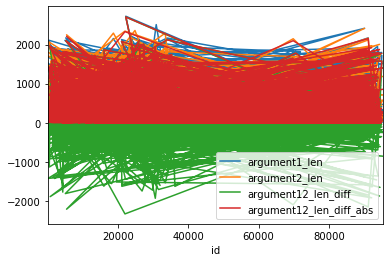

In [35]:
FPFN_df.plot()

---

### Make final results/predictions

In [137]:
model, vocabulary, ctx, tokenizer, transform, loss_function, metric, all_labels = setup_bert()

BERTModel(
  (encoder): BERTEncoder(
    (dropout_layer): Dropout(p = 0.1, axes=())
    (layer_norm): BERTLayerNorm(eps=1e-12, axis=-1, center=True, scale=True, in_channels=768)
    (transformer_cells): HybridSequential(
      (0): BERTEncoderCell(
        (dropout_layer): Dropout(p = 0.1, axes=())
        (attention_cell): MultiHeadAttentionCell(
          (_base_cell): DotProductAttentionCell(
            (_dropout_layer): Dropout(p = 0.1, axes=())
          )
          (proj_query): Dense(768 -> 768, linear)
          (proj_key): Dense(768 -> 768, linear)
          (proj_value): Dense(768 -> 768, linear)
        )
        (proj): Dense(768 -> 768, linear)
        (ffn): BERTPositionwiseFFN(
          (ffn_1): Dense(768 -> 3072, linear)
          (activation): GELU()
          (ffn_2): Dense(3072 -> 768, linear)
          (dropout_layer): Dropout(p = 0.1, axes=())
          (layer_norm): BERTLayerNorm(eps=1e-12, axis=-1, center=True, scale=True, in_channels=768)
        )
        (la

In [138]:
# model.load_parameters('data/within_traindev_proepi512_BCE/bert.model.checkpoint4.params', ctx=ctx)
model.load_parameters('data/within_traindev_proepi512_BCE_0.1/bert.model.checkpoint3.params', ctx=ctx)

In [139]:
#X_pred = within_test_df[['argument1', 'argument2', 'topic']]
X_pred = cross_test_df[['argument1', 'argument2', 'topic']]
y_pred = None

_, data_pred = transform_dataset(X_pred, y_pred, transform)

In [116]:
# data_pred_raw[0]

['i would like to start off by thanking my opponent for his first debate, and hope that he has many more to come. claiming that something should be maintain simply because it is tradition is a common falacy, known as appeal to tradition. examples of how this is not an adequate reason to preserve something by itself are such issues as slavery, and discrimination of women. simply because that is the way things were, does not mean that is the way thing ought be. i would also like to question my opponent\'s claim that, "i believe it is the child who chooses to become gay in a more mature state of mind." if a child can simply "choose" to be gay, then they can "choose" to not be gay. also, if someone is capable of such a choice, then my opponent would be able to simply become gay for 30 minutes, then become straight again, as would i and anyone else reading and voting on this debate. as of now, i have not found the way to choose to be gay. even so, i don\'t see how choosing or not choosing t

In [114]:
# data_pred[0]

(array([    2,  1045,  2052,  2066,  2000,  2707,  2125,  2011, 28638,
         2026,  7116,  2005,  2010,  2034,  5981,  1010,  1998,  3246,
         2008,  2002,  2038,  2116,  2062,  2000,  2272,  1012,  6815,
         2008,  2242,  2323,  2022,  5441,  3432,  2138,  2009,  2003,
         4535,  2003,  1037,  2691,  6904,  2721,  5666,  1010,  2124,
         2004,  5574,  2000,  4535,  1012,  4973,  1997,  2129,  2023,
         2003,  2025,  2019, 11706,  3114,  2000,  7969,  2242,  2011,
         2993,  2024,  2107,  3314,  2004,  8864,  1010,  1998,  9147,
         1997,  2308,  1012,  3432,  2138,  2008,  2003,  1996,  2126,
         2477,  2020,  1010,  2515,  2025,  2812,  2008,  2003,  1996,
         2126,  2518, 11276,  2022,  1012,  1045,  2052,  2036,  2066,
         2000,  3160,  2026,  7116,  1005,  1055,  4366,  2008,  1010,
         1000,  1045,  2903,  2009,  2003,  1996,  2775,  2040, 15867,
         2000,  2468,  5637,  1999,  1037,  2062,  9677,  2110,  1997,
      

In [140]:
# label_map=all_labels
predictions = predict_unknown(model, data_pred, ctx, label_map=None, batch_size=1)

Time for [prediction]: 0:09:45.098011


In [141]:
assert len(data_pred) == len(predictions) == len(X_pred)

In [142]:
# convert predictions to dataframe
# bool works because we mapped 0 to False, 1 to True, is default conversion
test_pred_df = pd.DataFrame(data=predictions, columns=["prediction"], dtype="bool")

# merge all dataframes
# test_df = X_pred.join(y_pred)
test_df = X_pred.reset_index()
test_df = pd.merge(test_df, test_pred_df, left_index=True, right_index=True, how='inner')
test_df.set_index('id', inplace=True)

# re-apply tag value
test_df = test_df.progress_apply(add_tag, axis=1)
# info
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6163 entries, 0 to 34329
Data columns (total 5 columns):
argument1     6163 non-null object
argument2     6163 non-null object
topic         6163 non-null object
prediction    6163 non-null bool
tag           6163 non-null object
dtypes: bool(1), object(4)
memory usage: 246.8+ KB


In [143]:
import pickle

# ser_fn = "data/within_traindev_proepi512_BCE/within_test_pred_df.pickle"
# ser_fn = "data/within_traindev_proepi512_BCE_0.1/within_test_pred_df.pickle"
ser_fn = "data/within_traindev_proepi512_BCE_0.1/cross_with_within_model_test_pred_df.pickle"

with open(ser_fn, "wb") as f:
    pickle.dump(test_df, f, protocol=pickle.HIGHEST_PROTOCOL)

In [144]:
next(test_df.itertuples())

Pandas(Index=0, argument1='i would like to start off by thanking my opponent for his first debate, and hope that he has many more to come. claiming that something should be maintain simply because it is tradition is a common falacy, known as appeal to tradition. examples of how this is not an adequate reason to preserve something by itself are such issues as slavery, and discrimination of women. simply because that is the way things were, does not mean that is the way thing ought be. i would also like to question my opponent\'s claim that, "i believe it is the child who chooses to become gay in a more mature state of mind." if a child can simply "choose" to be gay, then they can "choose" to not be gay. also, if someone is capable of such a choice, then my opponent would be able to simply become gay for 30 minutes, then become straight again, as would i and anyone else reading and voting on this debate. as of now, i have not found the way to choose to be gay. even so, i don\'t see how c

In [145]:
# res_fn = "data/within_traindev_proepi512_BCE/within_results.csv"
# res_fn = "data/within_traindev_proepi512_BCE_0.1/within_results.csv"
res_fn = "data/within_traindev_proepi512_BCE_0.1/cross_with_within_model_results.csv"

with open(res_fn, "w") as of:
    of.write('"id","label"\n')
    for row_id, row in test_df.iterrows():
        of.write('{},"{}"\n'.format(row_id, str(row['prediction'])))

**NOTE**: do this for within and cross !!!

In [150]:
# test read
temp_test_df = pd.read_csv("data/within_traindev_proepi512_BCE_0.1/cross_with_within_model_results.csv", index_col='id')
temp_test_df.info()
temp_test_df.iloc[10]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6163 entries, 0 to 34329
Data columns (total 1 columns):
label    6163 non-null bool
dtypes: bool(1)
memory usage: 54.2 KB


label    False
Name: 16, dtype: bool